# **Fractal and Volatility Features for Predicting Price Direction: A Walk-Forward Approach**

# **1. Introduction, Scope, and Limitation**


**A. Introduction**


This notebook presents a framework for building and evaluating a time-series classification model aimed at predicting directional price movements. It focuses on using fractal and volatility features derived *only* from past price data. The evaluation employs a rigorous walk-forward validation scheme with a purge period to prevent look-ahead bias, probability calibration to ensure reliable predictions, and a threshold optimization process to maximize the Matthews Correlation Coefficient (MCC). A basic PnL (Profit and Loss) sanity check is included at the end to give an initial sense of potential trading performance.





**B. Scope and Limitations**


The scope is limited to predicting the *direction* of price movement over a fixed horizon using only the specified past price features. It does not attempt to predict the magnitude of price changes or incorporate external data sources. The backtesting is a simple sanity check and does not account for real-world factors like slippage (beyond basic transaction costs), exchange fees, funding costs (for leveraged positions), or realistic market microstructure effects. The model is trained and evaluated on historical data and its future performance is not guaranteed. The walk-forward setup, while robust, depends on the chosen fold sizes and gap.






**2. Model Modules and Implementation**


The model is implemented using a pipeline approach, combining feature preprocessing (standardization) with a base classifier (XGBoost). Key aspects include:

- **Feature Engineering:** Calculation of fractal features (Hurst Exponent via R/S, DFA alpha), volatility measures (realized volatility, bipower variation), and rolling autocorrelation of absolute returns. Optional wavelet energy features are also included.
- **Labeling:** Supports both fixed-horizon log-return labeling with a dead zone and a triple-barrier method based on dynamic volatility thresholds and a maximum holding period.
- **Walk-Forward Validation:** The core evaluation uses a time-series friendly walk-forward split with a purge period to maintain causality.
- **Model Training:** An XGBoost classifier is used, with `scale_pos_weight` adjusted per-fold to handle class imbalance.
- **Probability Calibration:** A `CalibratedClassifierCV` wrapper is used to improve the reliability of predicted probabilities, which are crucial for threshold optimization and risk management.
- **Threshold Optimization:** The decision threshold for converting probabilities to binary predictions is optimized per-fold (or globally on OOF data) to maximize MCC.
- **Evaluation Metrics:** Robust metrics are reported, including ROC-AUC, PR-AUC, Brier Score, and MCC.
- **Diagnostics:** Includes a reliability diagram for calibration assessment and permutation feature importance for understanding feature relevance.
- **PnL Sanity Check:** A basic backtest on out-of-fold data is performed to provide a preliminary view of potential strategy performance, incorporating simple transaction costs.









**Key Points:**

Limited to predicting price direction over a fixed horizon.
Uses only specified past price features; no magnitude prediction or external data.
Basic backtesting; does not account for slippage (beyond basic TC), fees, funding, microstructure.
Future performance not guaranteed.
Walk-forward setup depends on chosen fold sizes and gap.

# **2. Setup & Imports**

In [ ]:
# If needed in a fresh env, uncomment to install:
# !pip install --quiet numpy pandas scipy scikit-learn xgboost statsmodels pywavelets matplotlib yfinance

import warnings, numpy as np, pandas as pd
warnings.filterwarnings('ignore')
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)


# **3. Configuration & Data Loading**

In [ ]:
# Section 3 — Configuration & Data Loading (robust yfinance)

USE_YFINANCE   = True       # fetch with yfinance
USE_SYNTHETIC  = False      # not used when yfinance=True
CSV_PATH       = 'your_prices.csv'  # unused here
DATE_COL       = 'Date'

# yfinance params
TICKER = "SPY"          # or your preferred symbol, e.g., "^GSPC", "AAPL"
START  = "2015-01-01"
END    = "2025-01-01"

def _flatten_yf_columns(df, ticker):
    """
    Handle both shapes from yfinance:
    - Single-level columns: ['Open','High','Low','Close','Adj Close','Volume']
    - MultiIndex columns:
        (a) top level = fields, second level = tickers
        (b) top level = tickers, second level = fields
    Returns a DataFrame with single-level columns for one ticker.
    """
    if not isinstance(df.columns, pd.MultiIndex):
        return df  # already flat

    lvl0 = df.columns.get_level_values(0)
    lvl1 = df.columns.get_level_values(1)

    if ticker in lvl0:
        sub = df[ticker]  # top level is ticker
    elif ticker in lvl1:
        sub = df.xs(ticker, axis=1, level=1)  # second level is ticker
    else:
        # Fallback: if only one ticker is present, use it
        uniq0, uniq1 = sorted(set(lvl0)), sorted(set(lvl1))
        if len(uniq0) == 1 and uniq0[0] not in ['Open','High','Low','Close','Adj Close','Volume']:
            sub = df.xs(uniq0[0], axis=1, level=0)
        elif len(uniq1) == 1:
            sub = df.xs(uniq1[0], axis=1, level=1)
        else:
            raise ValueError(
                f"Ticker '{ticker}' not found in yfinance columns. "
                f"Level0={uniq0[:6]}..., Level1={uniq1[:6]}..."
            )
    # Ensure simple string column names
    sub.columns = [str(c) for c in sub.columns]
    return sub

def load_price_data():
    if USE_YFINANCE:
        try:
            import yfinance as yf
        except ImportError:
            raise ImportError("yfinance not installed. Uncomment the pip install cell in Section 2 and rerun.")

        # Be explicit: some versions differ on group_by default
        df = yf.download(
            TICKER, start=START, end=END,
            auto_adjust=False, progress=False, group_by='ticker'
        )
        if df.empty:
            raise ValueError("Downloaded data is empty. Check ticker or date range.")

        df = _flatten_yf_columns(df, TICKER)

        # Standardize column names
        cmap = {
            'open':'Open','high':'High','low':'Low','close':'Close',
            'adj close':'Adj Close','volume':'Volume'
        }
        df = df.rename(columns={c: cmap.get(c.lower(), c) for c in df.columns})

        # Keep core OHLCV (drop missing if not present)
        keep = [c for c in ['Open','High','Low','Close','Volume'] if c in df.columns]
        df = df[keep].copy()

        # Index → column "Date"
        df.index = pd.to_datetime(df.index)
        df.index.name = 'Date'
        df = df.sort_index()
        df = df.loc[~df.index.duplicated(keep='first')]

        # Clean types
        for c in keep:
            df[c] = pd.to_numeric(df[c], errors='coerce')
        df = df.dropna(subset=['Close']).reset_index()  # bring 'Date' back as a column

    elif USE_SYNTHETIC:
        # Not used when USE_YFINANCE=True, but kept for completeness
        n = 4000
        idx = pd.date_range('2015-01-01', periods=n, freq='B')
        z = np.random.standard_t(df=5, size=n) * 0.008
        vol = pd.Series(z).rolling(50).std().bfill().values
        r = z * (0.6 + 4.0*vol)
        price = 100*np.exp(pd.Series(r).cumsum())
        close = price.values
        high = close*(1+np.random.rand(n)*0.005)
        low  = close*(1-n*np.random.rand(n)*0.005)
        openp= close*(1+np.random.randn(n)*0.001)
        volm = np.random.randint(1e5, 3e5, size=n)
        df = pd.DataFrame({'Date':idx,'Open':openp,'High':high,'Low':low,'Close':close,'Volume':volm})
        df['Date'] = pd.to_datetime(df['Date'])
        df = df.sort_values('Date').drop_duplicates('Date').reset_index(drop=True)

    else:
        # CSV fallback (unused here)
        df = pd.read_csv(CSV_PATH)
        df.columns = [c.strip() for c in df.columns]
        ren = {}
        for c in df.columns:
            cl = c.lower()
            if cl=='date': ren[c] = 'Date'
            elif cl=='open': ren[c] = 'Open'
            elif cl=='high': ren[c] = 'High'
            elif cl=='low': ren[c] = 'Low'
            elif cl=='close': ren[c] = 'Close'
            elif cl=='volume': ren[c] = 'Volume'
        df = df.rename(columns=ren)
        df['Date'] = pd.to_datetime(df['Date'])
        df = df.sort_values('Date').drop_duplicates('Date').reset_index(drop=True)

    return df

prices = load_price_data()
print(prices.head())
print(f"Loaded {len(prices)} rows from yfinance for {TICKER} [{START} → {END}].")


        Date        Open        High         Low       Close     Volume
0 2015-01-02  206.380005  206.880005  204.179993  205.429993  121465900
1 2015-01-05  204.169998  204.369995  201.350006  201.720001  169632600
2 2015-01-06  202.089996  202.720001  198.860001  199.820007  209151400
3 2015-01-07  201.419998  202.720001  200.880005  202.309998  125346700
4 2015-01-08  204.009995  206.160004  203.990005  205.899994  147217800
Loaded 2516 rows from yfinance for SPY [2015-01-01 → 2025-01-01].


# **4.1. Basic helpers (returns, vol, ranges, rolling ACF of |returns|)**

In [ ]:
# --- 4.1 Basic Helpers: returns, volatility, ranges, rolling ACF(|returns|) ---
import numpy as np
import pandas as pd
from typing import Iterable

def logret(x: pd.Series) -> pd.Series:
    """Log returns of a price series."""
    return np.log(x).diff()

def realized_vol(r: pd.Series, window: int = 20) -> pd.Series:
    """Annualized realized volatility over a rolling window."""
    return r.rolling(window).std() * np.sqrt(252)

def bipower_variation(r: pd.Series, window: int = 20) -> pd.Series:
    """Bipower variation (annualized) as a robust volatility proxy."""
    lam = np.pi / 2
    a = r.abs()
    prod = a * a.shift(1)
    return lam * prod.rolling(window).mean() * 252

def hl_range(df: pd.DataFrame) -> pd.Series:
    """High–low range normalized by Close."""
    return (df['High'] - df['Low']) / df['Close']

def rolling_acf_absr(series: pd.Series, lags: Iterable[int] = (1,2,3,4,5), window: int = 256) -> pd.DataFrame:
    """Rolling autocorrelation of absolute returns (volatility clustering proxy)."""
    out = pd.DataFrame(index=series.index)
    x = series.values
    for lag in lags:
        vals = []
        for i in range(len(x)):
            if i < window:
                vals.append(np.nan)
                continue
            w = np.abs(x[i-window:i])
            y = w[lag:]
            z = w[:-lag]
            if y.std(ddof=1) == 0 or z.std(ddof=1) == 0:
                vals.append(np.nan)
            else:
                vals.append(np.corrcoef(y, z)[0, 1])
        out[f'acf_absr_lag{lag}_{window}'] = vals
    return out


# **4.2. Fractal feature: Hurst exponent via rescaled-range (R/S)**

In [ ]:
# --- 4.2 Hurst Exponent via R/S ---
import statsmodels.api as sm
import numpy as np
import pandas as pd

def _rs_block(seg: np.ndarray) -> float:
    y = seg - seg.mean()
    z = np.cumsum(y)
    R = z.max() - z.min()
    S = y.std(ddof=1)
    return np.log(R / S) if S > 0 else np.nan

def rolling_hurst_rs(series: pd.Series, window: int = 512,
                     scales = (16, 24, 36, 48, 64, 96, 128)) -> pd.Series:
    """
    Rolling Hurst estimate using multi-scale R/S regression.
    Returns a per-row estimate using only past data.
    """
    out = []
    s = series.values.astype(float)
    for i in range(len(s)):
        if i < window:
            out.append(np.nan)
            continue
        xw = s[i-window:i]
        vals, ns = [], []
        for n in scales:
            if n >= window:
                break
            chunks = len(xw) // n
            if chunks < 4:
                continue
            rs_vals = []
            for k in range(chunks):
                seg = xw[k*n:(k+1)*n]
                rs = _rs_block(seg)
                if not np.isnan(rs):
                    rs_vals.append(np.exp(rs))  # back-transform before averaging
            if len(rs_vals) >= 3:
                vals.append(np.log(np.mean(rs_vals)))
                ns.append(np.log(n))
        if len(ns) >= 3:
            X = sm.add_constant(ns)
            beta = sm.OLS(vals, X).fit().params
            H = beta[1]  # slope
            out.append(H)
        else:
            out.append(np.nan)
    return pd.Series(out, index=series.index, name=f"H_RS_{window}")


# **4.3. Fractal feature: DFA (detrended fluctuation analysis) alpha**

In [ ]:
# --- 4.3 DFA Alpha ---
import numpy as np
import pandas as pd
import statsmodels.api as sm

def dfa_alpha(series: pd.Series, window: int = 512, order: int = 1,
              scales = (16, 24, 36, 48, 64, 96, 128)) -> pd.Series:
    """
    Rolling DFA alpha using multi-scale regression on log F(n) vs log n.
    Past-only per-row computation.
    """
    out = []
    x = series.values.astype(float)
    for i in range(len(x)):
        if i < window:
            out.append(np.nan)
            continue
        w = x[i-window:i]
        y = np.cumsum(w - w.mean())
        Fn, ln_n = [], []
        for n in scales:
            if n >= window:
                break
            chunks = len(y) // n
            if chunks < 4:
                continue
            errs = []
            for k in range(chunks):
                seg = y[k*n:(k+1)*n]
                t = np.arange(n)
                coeff = np.polyfit(t, seg, order)
                trend = np.polyval(coeff, t)
                errs.append(np.sqrt(np.mean((seg - trend) ** 2)))
            Fn.append(np.mean(errs))
            ln_n.append(np.log(n))
        if len(ln_n) >= 3:
            X = sm.add_constant(ln_n)
            alpha = sm.OLS(np.log(Fn), X).fit().params[1]
            out.append(alpha)
        else:
            out.append(np.nan)
    return pd.Series(out, index=series.index, name=f"DFA_{window}")


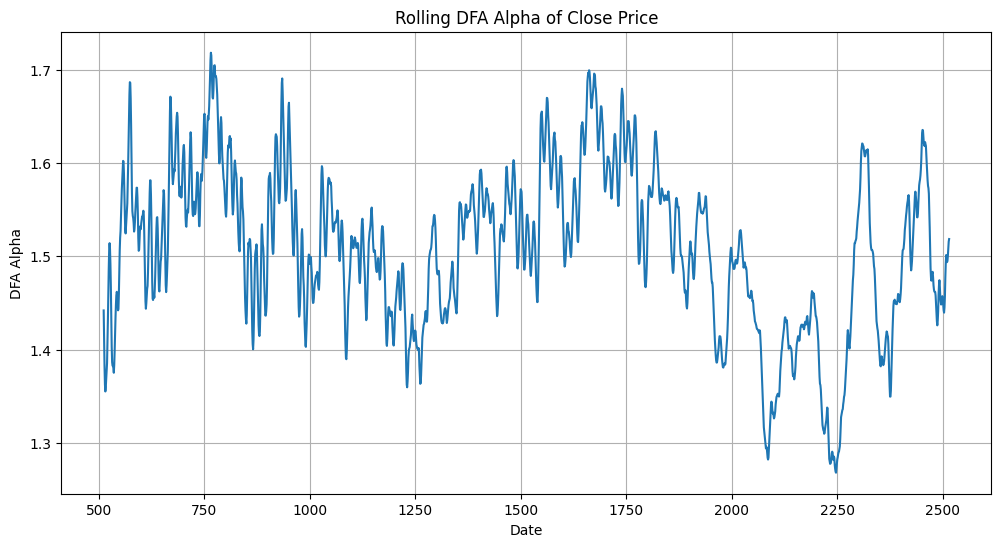

In [ ]:
import matplotlib.pyplot as plt

# Calculate DFA alpha using the Close price series
# You can adjust the window size as needed, matching the value used in feature engineering
dfa_alpha_series = dfa_alpha(prices['Close'], window=512)

# Plot the DFA alpha time series
plt.figure(figsize=(12, 6))
dfa_alpha_series.plot()
plt.title('Rolling DFA Alpha of Close Price')
plt.xlabel('Date')
plt.ylabel('DFA Alpha')
plt.grid(True)
plt.show()

# **4.4. Optional: wavelet energy features (toggleable)**

In [ ]:
# --- 4.4 Wavelet Energy (optional) ---
# Toggle this to True if you want wavelet features (slower on long series)
USE_WAVELETS = False
WAVELET      = 'db2'
WAVELET_LVL  = 4

import numpy as np
import pandas as pd

def wavelet_energy_features(series: pd.Series, window: int = 512,
                            wavelet: str = 'db2', levels: int = 4) -> pd.DataFrame:
    """
    Energy share of detail coefficients across levels (normalized) over a rolling window.
    Imported locally so the cell runs even if PyWavelets isn't installed and you keep USE_WAVELETS=False.
    """
    import pywt  # local import to avoid hard dependency if not using wavelets
    idx = series.index
    cols = {f'wl_Ed{j}_{window}': [] for j in range(1, levels+1)}
    x = series.values
    for i in range(len(x)):
        if i < window:
            for j in range(1, levels+1):
                cols[f'wl_Ed{j}_{window}'].append(np.nan)
            continue
        w = x[i-window:i]
        coeffs = pywt.wavedec(w, wavelet, level=levels)
        details = coeffs[1:]                     # [cD_levels ... cD1]
        en = [float(np.sum(d**2)) for d in details[::-1]]  # energy d1..dL
        tot = sum(en)
        for j, e in enumerate(en, start=1):
            cols[f'wl_Ed{j}_{window}'].append((e / tot) if tot > 0 else np.nan)
    return pd.DataFrame(cols, index=idx)


In [ ]:
import matplotlib.pyplot as plt

if USE_WAVELETS:
    print(f"Calculating wavelet energy features with wavelet='{WAVELET}' and levels={WAVELET_LVL}...")
    # Calculate wavelet energy features using the Close price series
    # Adjust window, wavelet, and levels as needed
    wavelet_features_df = wavelet_energy_features(
        prices['Close'],
        window=512, # Match window size used in feature engineering
        wavelet=WAVELET,
        levels=WAVELET_LVL
    )

    # Plot the wavelet energy features time series
    plt.figure(figsize=(12, 6))
    wavelet_features_df.plot(ax=plt.gca()) # Plot on the current axes
    plt.title('Rolling Wavelet Energy Features of Close Price')
    plt.xlabel('Date')
    plt.ylabel('Normalized Energy Share')
    plt.grid(True)
    plt.legend(title='Detail Level')
    plt.show()
else:
    print("USE_WAVELETS is set to False. Skipping wavelet feature calculation and plotting.")

USE_WAVELETS is set to False. Skipping wavelet feature calculation and plotting.


# **5.1. Label configuration**

In [ ]:
# --- 5.1 Label Configuration ---
from dataclasses import dataclass

@dataclass
class LabelConfig:
    method: str = 'horizon'   # 'horizon' or 'triple_barrier'
    # Horizon labels
    horizon: int = 20         # bars ahead
    dead_zone: float = 0.0002 # ignore tiny moves (log-return threshold)
    # Triple-barrier params
    tb_pt: float = 2.0        # profit-taking multiple (× vol)
    tb_sl: float = 2.0        # stop-loss multiple (× vol)
    tb_max_h: int = 50        # max holding period (bars)
    vol_ewm_span: int = 50    # span for EWM volatility estimator

# choose your default here
LABEL_CFG = LabelConfig(method='horizon', horizon=20, dead_zone=0.0002)


# **5.2. Horizon labeling (with dead-zone)**

In [ ]:
# --- 5.2 Horizon Labeling (with dead-zone) ---
import numpy as np
import pandas as pd

def compute_labels_horizon(df: pd.DataFrame, horizon: int = 20, dead_zone: float = 0.0) -> pd.Series:
    """
    Binary label from future log return over a fixed horizon.
      y = 1 if future logret > +dead_zone
      y = 0 if future logret < -dead_zone
      y = NaN otherwise (ignored)
    """
    px = df['Close'].astype(float)
    fwd = np.log(px).shift(-horizon) - np.log(px)
    y = pd.Series(np.nan, index=px.index)
    y[fwd >  dead_zone] = 1
    y[fwd < -dead_zone] = 0
    return y


# **5.3. Triple-barrier labeling**

In [ ]:
# --- 5.3 Triple-Barrier Labeling ---
import numpy as np
import pandas as pd

def compute_labels_triple_barrier(
    df: pd.DataFrame,
    pt_mult: float = 2.0,
    sl_mult: float = 2.0,
    max_h: int = 50,
    vol_ewm_span: int = 50
) -> pd.Series:
    """
    Triple-barrier labels:
      - dynamic PT/SL set from EWM volatility of log returns
      - outcome is which barrier is hit first (1=PT, 0=SL)
      - if neither is hit by max_h, fallback to sign(px[t+max_h] - px[t])
    """
    px = df['Close'].astype(float).values
    idx = df.index
    r = pd.Series(np.log(df['Close']).diff(), index=idx)
    vol = r.ewm(span=vol_ewm_span).std().values

    y = np.full(len(px), np.nan)
    n = len(px)
    for t in range(n):
        if t >= n - 1:
            break
        p0 = px[t]
        # dynamic barriers
        up = p0 * np.exp(pt_mult * (vol[t] if not np.isnan(vol[t]) else 0.0))
        dn = p0 * np.exp(-sl_mult * (vol[t] if not np.isnan(vol[t]) else 0.0))
        last = min(t + max_h, n - 1)

        label = np.nan
        for u in range(t + 1, last + 1):
            pu = px[u]
            if pu >= up:
                label = 1
                break
            if pu <= dn:
                label = 0
                break
        if np.isnan(label):
            # fallback at horizon end
            label = 1 if px[last] > p0 else 0
        y[t] = label

    return pd.Series(y, index=idx, name='target')


# **5.4. Label dispatcher + quick sanity check**

In [ ]:
# --- 5.4 Label Dispatcher + Sanity Check ---
import pandas as pd
import numpy as np

def compute_labels(df: pd.DataFrame, cfg: LabelConfig) -> pd.Series:
    if cfg.method == 'horizon':
        return compute_labels_horizon(df, horizon=cfg.horizon, dead_zone=cfg.dead_zone)
    elif cfg.method == 'triple_barrier':
        return compute_labels_triple_barrier(
            df,
            pt_mult=cfg.tb_pt,
            sl_mult=cfg.tb_sl,
            max_h=cfg.tb_max_h,
            vol_ewm_span=cfg.vol_ewm_span
        )
    else:
        raise ValueError(f"Unknown method: {cfg.method}")

# example: build labels now (features will be in Section 6)
y_preview = compute_labels(prices, LABEL_CFG)
print("Label preview (head):")
print(y_preview.head(10))
print("\nClass balance (ignoring NaNs):")
print(y_preview.value_counts(dropna=True).rename({0.0:"class 0", 1.0:"class 1"}))
print("\nNaN rate (dead-zone ignored rows):", np.mean(y_preview.isna()).round(4))


Label preview (head):
0    0.0
1    1.0
2    1.0
3    1.0
4    0.0
5    1.0
6    1.0
7    1.0
8    1.0
9    1.0
dtype: float64

Class balance (ignoring NaNs):
class 1    1675
class 0     816
Name: count, dtype: int64

NaN rate (dead-zone ignored rows): 0.0099


# **6.1. Feature params + base series**

In [ ]:
# --- 6.1 Feature params + base series ---

# Rolling window choices (tweak as you like)
WIN_SHORT = 256
WIN_LONG  = 512

# Build base returns & simple vol/range features (all past-only)
prices['logret'] = logret(prices['Close'])
prices['hl_range'] = hl_range(prices)
prices['rv20'] = realized_vol(prices['logret'], 20)
prices['rv60'] = realized_vol(prices['logret'], 60)
prices['bv20'] = bipower_variation(prices['logret'], 20)
prices['bv60'] = bipower_variation(prices['logret'], 60)

print("Base columns now available:", [c for c in ['logret','hl_range','rv20','rv60','bv20','bv60'] if c in prices.columns])
prices[['Date','Close','logret','rv20','hl_range']].head()


Base columns now available: ['logret', 'hl_range', 'rv20', 'rv60', 'bv20', 'bv60']


,Date,Close,logret,rv20,hl_range
0,2015-01-02,205.429993,NaN,NaN,0.013143
1,2015-01-05,201.720001,-0.018225,NaN,0.014971
2,2015-01-06,199.820007,-0.009464,NaN,0.019317
3,2015-01-07,202.309998,0.012384,NaN,0.009095
4,2015-01-08,205.899994,0.017589,NaN,0.010539


# **6.2. Compute fractal, ACF, and optional wavelet features**

In [ ]:
# --- 6.2 Compute fractal, ACF, and optional wavelet features ---

# Fractal (Hurst via R/S and DFA) on log returns
H_RS_256 = rolling_hurst_rs(prices['logret'].fillna(0.0), window=WIN_SHORT)
H_RS_512 = rolling_hurst_rs(prices['logret'].fillna(0.0), window=WIN_LONG)
DFA_256  = dfa_alpha(prices['logret'].fillna(0.0), window=WIN_SHORT)
DFA_512  = dfa_alpha(prices['logret'].fillna(0.0), window=WIN_LONG)

# Volatility clustering proxy: rolling ACF of |returns|
ACF_256  = rolling_acf_absr(prices['logret'].fillna(0.0), lags=(1,2,3,4,5), window=WIN_SHORT)

# Optional wavelet energy features
WL_512 = None
if 'USE_WAVELETS' in globals() and USE_WAVELETS:
    WL_512 = wavelet_energy_features(prices['logret'].fillna(0.0), window=WIN_LONG,
                                     wavelet=WAVELET, levels=WAVELET_LVL)
    print("Wavelet features computed:", WL_512.columns.tolist())

print("Fractal/ACF features ready.")


Fractal/ACF features ready.


# **6.3. Assemble X and y, align & clean, preview**

In [ ]:
# --- 6.3 Assemble X and y, align & clean, preview ---

# Collect features into one table
feature_blocks = [
    prices[['hl_range','rv20','rv60','bv20','bv60']],
    H_RS_256, H_RS_512, DFA_256, DFA_512,
    ACF_256
]
if WL_512 is not None:
    feature_blocks.append(WL_512)

X = pd.concat(feature_blocks, axis=1)

# Labels (from Section 5)
y = compute_labels(prices, LABEL_CFG)

# Combine & drop rows with NaNs from rolling windows and dead-zone NaNs
df_all = pd.concat([prices[[DATE_COL, 'Close']], X, y.rename('target')], axis=1)
df_all = df_all.dropna().reset_index(drop=True)

# Final X/y
X_final = df_all.drop(columns=[DATE_COL, 'Close', 'target'])
y_final = df_all['target'].astype(int)

print("Dataset ready.")
print("X shape:", X_final.shape, "| y positives:", int(y_final.sum()), "/", len(y_final),
      "| pos rate:", round(y_final.mean(), 4))
print("\nFeature sample:")
display(X_final.head(10))

# Optional: save for inspection
# X_final.to_csv("X_features.csv", index=False)
# y_final.to_csv("y_labels.csv", index=False)


Dataset ready.
X shape: (1981, 14) | y positives: 1366 / 1981 | pos rate: 0.6896

Feature sample:


,hl_range,rv20,rv60,bv20,bv60,H_RS_256,H_RS_512,DFA_256,DFA_512,acf_absr_lag1_256,acf_absr_lag2_256,acf_absr_lag3_256,acf_absr_lag4_256,acf_absr_lag5_256
0,0.003127,0.066653,0.084022,0.004788,0.005798,0.630263,0.548440,0.411759,0.421245,0.266554,0.205537,0.172810,0.192901,0.214688
1,0.004331,0.066315,0.084459,0.004274,0.005741,0.608600,0.538247,0.422613,0.426849,0.271338,0.205309,0.166058,0.188220,0.208400
2,0.003969,0.060119,0.084300,0.003791,0.005760,0.604950,0.525046,0.423626,0.422443,0.273741,0.222606,0.174403,0.202457,0.206903
3,0.007038,0.061403,0.084841,0.003616,0.005808,0.604900,0.528980,0.446029,0.430885,0.275212,0.222179,0.173635,0.204930,0.207279
4,0.005910,0.061257,0.084752,0.003720,0.005885,0.602593,0.543874,0.457918,0.434769,0.257326,0.190191,0.189167,0.191933,0.212327
5,0.006810,0.061149,0.084605,0.003697,0.005854,0.617849,0.538293,0.420861,0.437781,0.241065,0.198201,0.181019,0.193660,0.196171
6,0.007953,0.064649,0.085118,0.003931,0.005919,0.602893,0.560778,0.394537,0.442270,0.254907,0.186577,0.184735,0.167542,0.179796
7,0.004617,0.070776,0.086150,0.004971,0.006247,0.617450,0.572002,0.405410,0.453013,0.259736,0.186611,0.195853,0.173875,0.185227
8,0.003052,0.070805,0.085841,0.005078,0.006255,0.576773,0.589177,0.422766,0.465538,0.260754,0.173387,0.186726,0.165840,0.178658
9,0.003625,0.063109,0.086003,0.004703,0.006265,0.597408,0.583292,0.434644,0.472620,0.261938,0.173477,0.188690,0.166834,0.179382


Plotting histograms for all features:


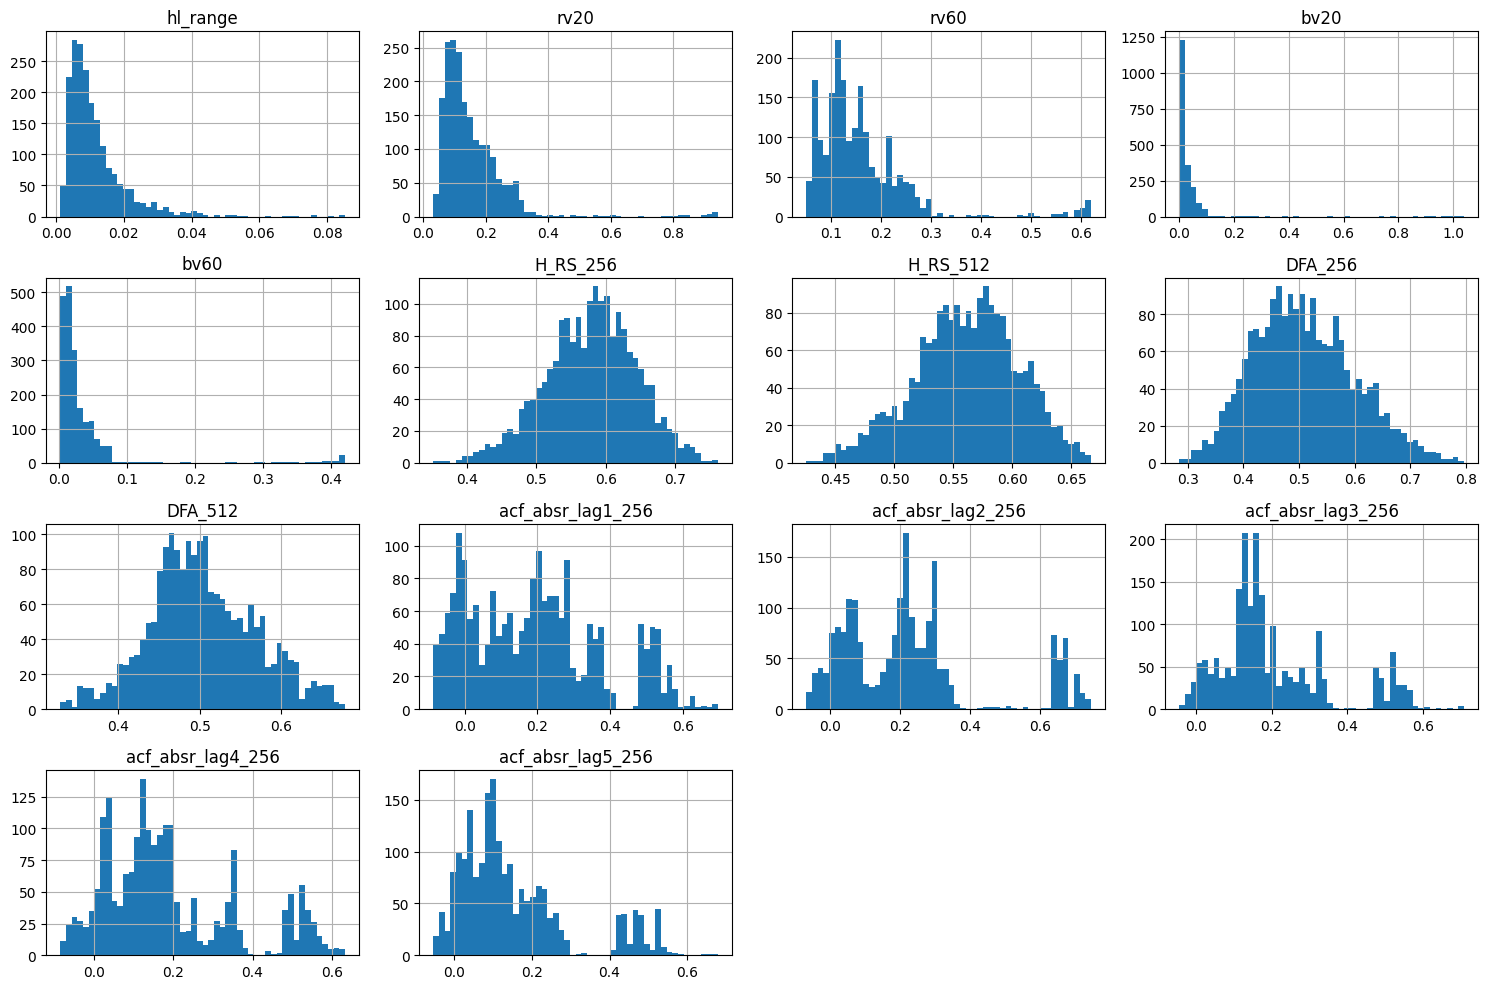

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Plot histograms for all features in X_final
print("Plotting histograms for all features:")
X_final.hist(figsize=(15, 10), bins=50)
plt.tight_layout()
plt.show()

Plotting time series for selected features:


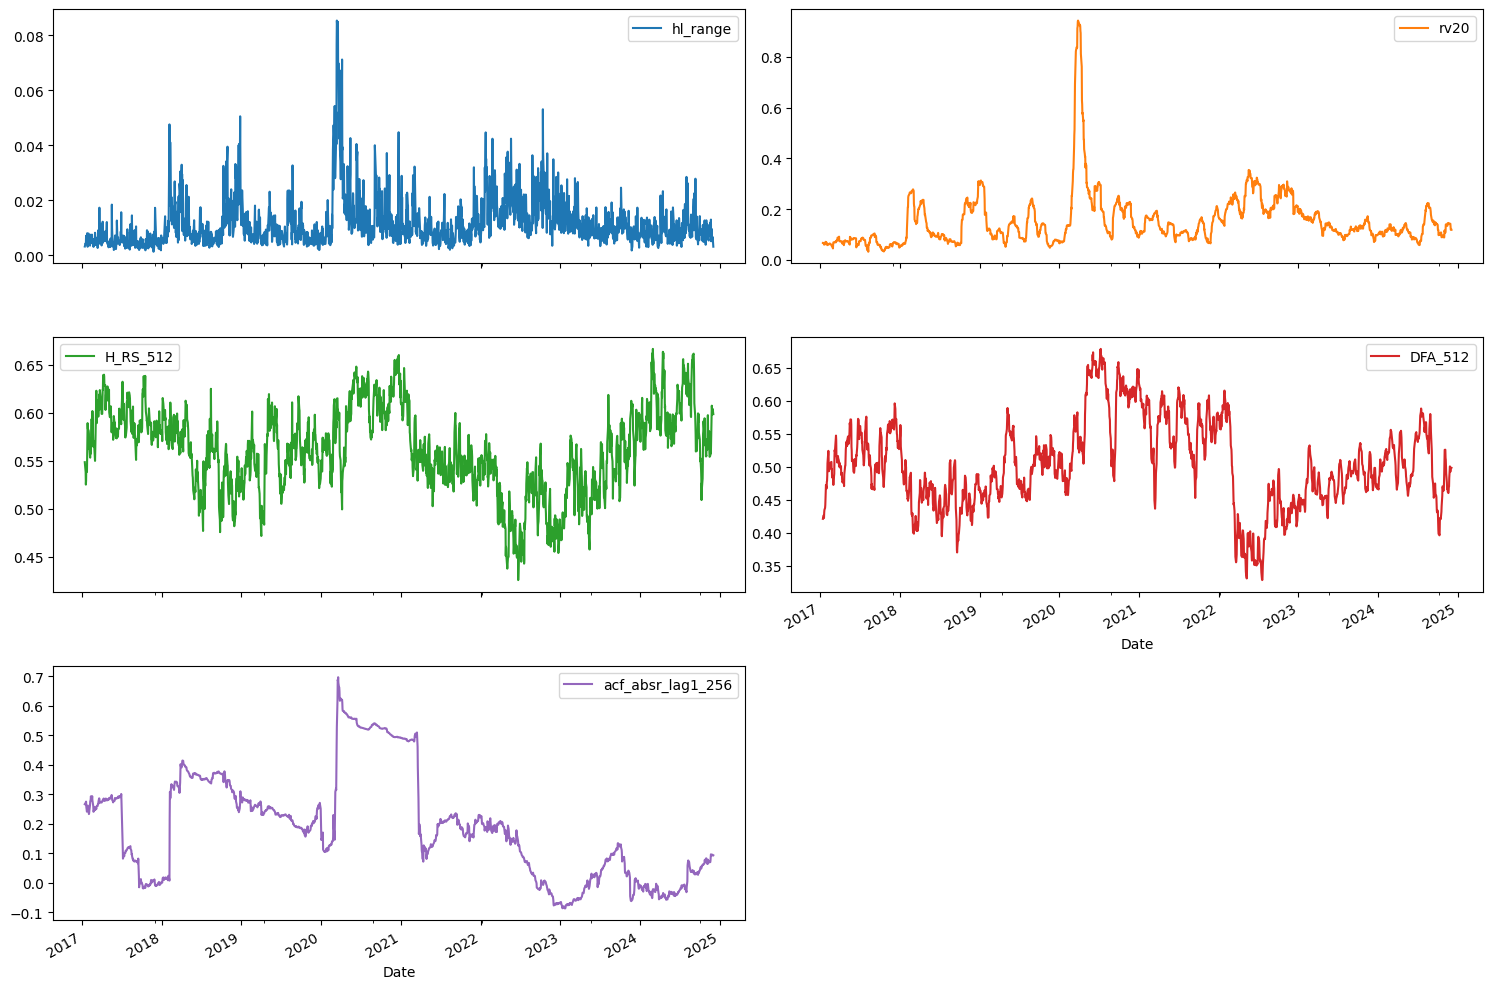

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Select a few features to plot as time series
# Choosing one from each category (range, volatility, Hurst, DFA, ACF)
selected_features = [
    'hl_range',
    'rv20',
    'H_RS_512',
    'DFA_512',
    'acf_absr_lag1_256',
]

# Add wavelet features if they exist and were used
if 'wl_Ed1_512' in X_final.columns:
     # Add the first detail level wavelet energy feature
     selected_features.append('wl_Ed1_512')


print("Plotting time series for selected features:")
# Use the original index from df_all for time series plotting
# df_all was created before dropping NaNs and resetting index, but keeping relevant columns
# Need to re-create a temporary df with Date index for plotting X_final with dates
temp_df = df_all[['Date'] + selected_features].set_index('Date')

temp_df.plot(figsize=(15, 10), subplots=True, layout=(-1, 2)) # Plot in subplots, 2 columns
plt.tight_layout()
plt.show()

# **7.1. Walk-forward config + helpers (splits, metrics, threshold search)**

In [ ]:
# --- 7.1 Walk-forward config + helpers ---

from typing import Iterator, Tuple
import numpy as np
import pandas as pd

# Heuristics for fold sizes (tweak as needed)
N_TOTAL   = len(y_final)
NUM_TRAIN = max(1000, int(N_TOTAL * 0.55))   # training rows per fold
NUM_TEST  = max(200,  int(N_TOTAL * 0.15))   # test rows per fold
GAP       = 5                                # purge gap between train and test

def forward_splits(n: int, train: int, test: int, gap: int = 0) -> Iterator[Tuple[slice, slice]]:
    """
    Yield (train_slice, test_slice) for a walk-forward scheme with a purge gap.
    Train/test are **lengths**, not indices. Slices are 0-based, half-open.
    """
    i = 0
    while i + train + gap + test <= n:
        tr = slice(i, i + train)
        te = slice(i + train + gap, i + train + gap + test)
        yield tr, te
        i += test  # slide window by test length each fold

# Metrics
from sklearn.metrics import (
    roc_auc_score, average_precision_score, brier_score_loss,
    matthews_corrcoef
)

def evaluate_probs(y_true: np.ndarray, p: np.ndarray, thr: float = 0.5) -> dict:
    """Return a dict of robust metrics for probabilistic outputs."""
    y_true = np.asarray(y_true)
    p = np.asarray(p)
    yhat = (p >= thr).astype(int)
    return dict(
        roc_auc = float(roc_auc_score(y_true, p)),
        pr_auc  = float(average_precision_score(y_true, p)),
        brier   = float(brier_score_loss(y_true, p)),
        mcc     = float(matthews_corrcoef(y_true, yhat)),
    )

def best_threshold(y_true: np.ndarray, p: np.ndarray, metric: str = "mcc") -> Tuple[float, float]:
    """
    Grid-search the decision threshold in [0.05..0.95] to maximize MCC (default).
    Returns (best_threshold, best_score).
    """
    y_true = np.asarray(y_true)
    p = np.asarray(p)
    grid = np.linspace(0.05, 0.95, 37)
    best_t, best_v = 0.5, -np.inf
    for t in grid:
        v = matthews_corrcoef(y_true, (p >= t).astype(int))
        if v > best_v:
            best_t, best_v = float(t), float(v)
    return best_t, best_v


# **7.2. Model: pipeline + calibration, walk-forward training loop**

In [ ]:
# --- 7.2 Pipeline + calibration, walk-forward loop ---

from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.calibration import CalibratedClassifierCV
from xgboost import XGBClassifier

# Calibration method: 'sigmoid' is safer on small samples; switch to 'isotonic' if you have plenty of data.
CALIB_METHOD = "sigmoid"

numeric_cols = list(X_final.columns)

def make_pipeline(scale_pos_weight: float = 1.0) -> Pipeline:
    pre = ColumnTransformer(
        transformers=[("num", StandardScaler(), numeric_cols)],
        remainder="drop",
        verbose_feature_names_out=False
    )
    base = XGBClassifier(
        n_estimators=500,
        max_depth=4,
        learning_rate=0.05,
        subsample=0.8,
        colsample_bytree=0.8,
        reg_lambda=1.0,
        reg_alpha=0.0,
        tree_method="hist",
        random_state=42,
        scale_pos_weight=scale_pos_weight,
        n_jobs=-1,
    )
    # Correct parameter name from base_estimator to estimator
    clf = CalibratedClassifierCV(estimator=base, cv=3, method=CALIB_METHOD)
    pipe = Pipeline([("prep", pre), ("clf", clf)])
    return pipe

# Walk-forward training
all_probs = np.full(shape=len(y_final), fill_value=np.nan, dtype=float)
fold_rows = []
fold_id = 0

for tr, te in forward_splits(len(y_final), NUM_TRAIN, NUM_TEST, GAP):
    fold_id += 1
    X_tr, y_tr = X_final.iloc[tr], y_final.iloc[tr]
    X_te, y_te = X_final.iloc[te], y_final.iloc[te]

    # class imbalance handling via scale_pos_weight = neg/pos
    pos = int(y_tr.sum())
    neg = int(len(y_tr) - pos)
    spw = (neg / pos) if pos > 0 else 1.0

    model = make_pipeline(scale_pos_weight=spw)
    model.fit(X_tr, y_tr)

    p = model.predict_proba(X_te)[:, 1]
    all_probs[te] = p

    # quick per-fold metrics at 0.5 threshold
    m = evaluate_probs(y_te.values, p, thr=0.5)
    fold_rows.append(dict(
        fold=fold_id, n_train=int(len(y_tr)), n_test=int(len(y_te)),
        pos_rate_train=float(y_tr.mean()), pos_rate_test=float(y_te.mean()),
        **m
    ))

fold_metrics = pd.DataFrame(fold_rows)
print("Per-fold metrics (thr=0.5):")
display(fold_metrics)
print("\nAverages (± std):")
print(fold_metrics[['roc_auc','pr_auc','brier','mcc']].agg(['mean','std']).round(4))

Per-fold metrics (thr=0.5):


,fold,n_train,n_test,pos_rate_train,pos_rate_test,roc_auc,pr_auc,brier,mcc
0,1,1089,297,0.728191,0.552189,0.68389,0.712995,0.262877,0.0
1,2,1089,297,0.685950,0.518519,0.29021,0.394073,0.269039,0.0



Averages (± std):
      roc_auc  pr_auc   brier  mcc
mean   0.4870  0.5535  0.2660  0.0
std    0.2784  0.2255  0.0044  0.0


# **7.3. Out-of-fold aggregation + threshold optimization**

In [ ]:
# --- 7.3 OOF aggregation + threshold optimization ---

mask = ~np.isnan(all_probs)
y_oof = y_final.values[mask]
p_oof = all_probs[mask]

print(f"OOF coverage: {mask.sum()} / {len(y_final)} rows")

# Metrics at default 0.5 threshold
base_scores = evaluate_probs(y_oof, p_oof, thr=0.5)
print("\nOOF metrics @ thr=0.5:", {k: round(v, 4) for k, v in base_scores.items()})

# Optimize threshold for MCC
t_best, m_best = best_threshold(y_oof, p_oof, metric="mcc")
opt_scores = evaluate_probs(y_oof, p_oof, thr=t_best)

print(f"\nBest threshold by MCC: {t_best:.3f}  (MCC={m_best:.4f})")
print("OOF metrics @ best thr:", {k: round(v, 4) for k, v in opt_scores.items()})

# Confusion matrix at best threshold (optional)
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_oof, (p_oof >= t_best).astype(int), labels=[0,1])
cm_df = pd.DataFrame(cm, index=["true_0","true_1"], columns=["pred_0","pred_1"])
print("\nConfusion matrix @ best thr:")
display(cm_df)

# Keep the OOF predictions if you want to analyze later
oof_df = pd.DataFrame({
    DATE_COL: df_all[DATE_COL].values[mask],
    "y_true": y_oof,
    "p_hat":  p_oof
})
print("\nOOF sample:")
display(oof_df.head(10))


OOF coverage: 594 / 1981 rows

OOF metrics @ thr=0.5: {'roc_auc': 0.5071, 'pr_auc': 0.6108, 'brier': 0.266, 'mcc': 0.0}

Best threshold by MCC: 0.725  (MCC=0.2080)
OOF metrics @ best thr: {'roc_auc': 0.5071, 'pr_auc': 0.6108, 'brier': 0.266, 'mcc': 0.208}

Confusion matrix @ best thr:


,pred_0,pred_1
true_0,257,19
true_1,249,69



OOF sample:


,Date,y_true,p_hat
0,2021-05-25,1,0.713942
1,2021-05-26,1,0.721942
2,2021-05-27,1,0.726313
3,2021-05-28,1,0.719596
4,2021-06-01,1,0.655640
5,2021-06-02,1,0.701260
6,2021-06-03,1,0.706658
7,2021-06-04,1,0.707113
8,2021-06-07,1,0.691602
9,2021-06-08,1,0.646199


# **8.1. Reliability diagram (calibration curve) from OOF predictions**

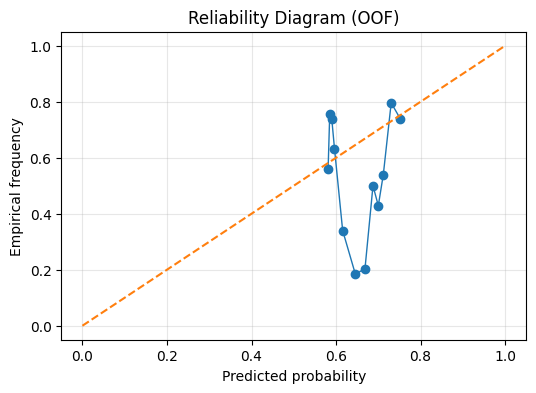

Expected Calibration Error (ECE), ~heuristic: 0.1906


In [ ]:
# --- 8.1 Reliability diagram (calibration curve) ---

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.calibration import calibration_curve

# guards
assert 'p_oof' in globals() and 'y_oof' in globals(), "Run Section 7 first (OOF predictions)."

prob_true, prob_pred = calibration_curve(y_oof, p_oof, n_bins=12, strategy="quantile")

plt.figure(figsize=(6,4))
plt.plot(prob_pred, prob_true, marker="o", linewidth=1)
plt.plot([0,1],[0,1], linestyle="--")
plt.xlabel("Predicted probability")
plt.ylabel("Empirical frequency")
plt.title("Reliability Diagram (OOF)")
plt.grid(True, alpha=0.3)
plt.show()

# simple calibration diagnostics
ece = float(np.mean(np.abs(prob_true - prob_pred)))
print(f"Expected Calibration Error (ECE), ~heuristic: {ece:.4f}")


# **8.2. Permutation feature importance (quick, holdout-style)**

In [ ]:
# --- 8.2 Permutation Feature Importance (holdout-style) ---

from sklearn.inspection import permutation_importance
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split

# We recompute a single fitted model on a holdout split (approximate)
X_tr, X_ho, y_tr, y_ho = train_test_split(
    X_final, y_final, test_size=0.25, shuffle=False
)

# rebalance weight using in-sample class ratio
pos = int(y_tr.sum()); neg = int(len(y_tr) - pos)
spw = (neg/pos) if pos>0 else 1.0
tmp_model = make_pipeline(scale_pos_weight=spw)  # from Section 7.2
tmp_model.fit(X_tr, y_tr)

# PI on the holdout set using ROC-AUC as the score
pi = permutation_importance(
    tmp_model, X_ho, y_ho,
    n_repeats=10, scoring="roc_auc", random_state=42, n_jobs=-1
)

imp_df = pd.DataFrame({
    "feature": X_final.columns,
    "importance_mean": pi.importances_mean,
    "importance_std":  pi.importances_std
}).sort_values("importance_mean", ascending=False)

print("Top 20 features by permutation importance (ROC-AUC on holdout):")
display(imp_df.head(20))


Top 20 features by permutation importance (ROC-AUC on holdout):


,feature,importance_mean,importance_std
11,acf_absr_lag3_256,0.053230,0.006757
9,acf_absr_lag1_256,0.044858,0.014878
4,bv60,0.033994,0.004563
1,rv20,0.027424,0.005847
3,bv20,0.025420,0.005245
12,acf_absr_lag4_256,0.019133,0.015415
13,acf_absr_lag5_256,0.018767,0.011867
10,acf_absr_lag2_256,0.008198,0.002352
0,hl_range,0.007162,0.004133
5,H_RS_256,-0.001180,0.005448


# **9.1. Backtest helpers**

In [ ]:
# --- 9.1 Backtest helpers ---

import numpy as np
import pandas as pd

def performance_stats(equity_curve, freq=252):
    """Return simple CAGR, Sharpe (daily->annual), and max drawdown."""
    rets = np.log(equity_curve).diff().dropna()
    ann_ret = float(np.exp(rets.mean()*freq) - 1.0)
    ann_vol = float(rets.std(ddof=1) * np.sqrt(freq))
    sharpe = float(ann_ret / ann_vol) if ann_vol>0 else np.nan
    peak = equity_curve.cummax()
    dd = (equity_curve/peak - 1.0)
    mdd = float(dd.min())
    return {"CAGR": ann_ret, "Sharpe": sharpe, "MaxDD": mdd}

def backtest_from_oof(oof_df, prices, t_best, tc_bps=5, mode="long_only"):
    """
    mode:
      - 'long_only': pos=1 if p>=t_best else 0
      - 'long_short': pos=+1 if p>=t_best, -1 if p<=1-t_best, else 0
    tc_bps: transaction cost in basis points per trade (applied on position change)
    """
    df = oof_df.merge(prices[[DATE_COL, 'logret']], on=DATE_COL, how='left')  # logret computed in 6.1
    df = df.sort_values(DATE_COL).reset_index(drop=True)

    # Next-period log-return as trade PnL driver
    df['r1'] = df['logret'].shift(-1)
    df = df.dropna(subset=['r1']).reset_index(drop=True)

    if mode == "long_only":
        df['pos'] = (df['p_hat'] >= t_best).astype(int)
    elif mode == "long_short":
        df['pos'] = 0
        df.loc[df['p_hat'] >= t_best, 'pos'] = 1
        df.loc[df['p_hat'] <= (1 - t_best), 'pos'] = -1
    else:
        raise ValueError("Unknown mode")

    # apply position with one-bar delay (enter next bar)
    df['pos_shift'] = df['pos'].shift(1).fillna(0)

    # turnover and transaction cost
    df['turnover'] = (df['pos_shift'] - df['pos_shift'].shift(1)).abs().fillna(df['pos_shift'].abs())
    tc = (tc_bps / 1e4)  # convert bps to decimal
    df['ret_strategy'] = df['pos_shift'] * df['r1'] - df['turnover'] * tc

    # equity curve
    df['equity'] = np.exp(df['ret_strategy'].cumsum())
    stats = performance_stats(df['equity'])

    return df, stats


# **9.2. Run backtest (long-only & long/short), plot curves, print stats**

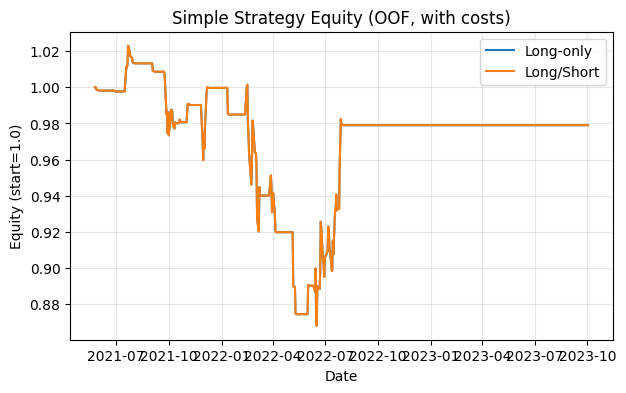

Long-only stats: {'CAGR': -0.009, 'Sharpe': -0.1091, 'MaxDD': -0.1514}
Long/Short stats: {'CAGR': -0.009, 'Sharpe': -0.1091, 'MaxDD': -0.1514}


In [ ]:
# --- 9.2 Run PnL sanity check ---

import matplotlib.pyplot as plt

# guards
assert 'oof_df' in globals() and 't_best' in globals(), "Run Section 7.3 first."

# Long-only
bt_long, st_long = backtest_from_oof(oof_df, prices, t_best=t_best, tc_bps=5, mode="long_only")
# Long/short (neutral zone between 1-t_best and t_best)
bt_ls, st_ls = backtest_from_oof(oof_df, prices, t_best=t_best, tc_bps=5, mode="long_short")

fig, ax = plt.subplots(figsize=(7,4))
ax.plot(bt_long[DATE_COL], bt_long['equity'], label="Long-only")
ax.plot(bt_ls[DATE_COL],   bt_ls['equity'],   label="Long/Short")
ax.set_title("Simple Strategy Equity (OOF, with costs)")
ax.set_xlabel(DATE_COL)
ax.set_ylabel("Equity (start=1.0)")
ax.grid(True, alpha=0.3)
ax.legend()
plt.show()

print("Long-only stats:", {k: round(v,4) for k,v in st_long.items()})
print("Long/Short stats:", {k: round(v,4) for k,v in st_ls.items()})


# **10.1. Compile a summary report (fold metrics, OOF metrics, calibration, PnL)**

In [ ]:
# --- 10.1 Compact Summary Report ---

import pandas as pd
import numpy as np

def exists(name: str) -> bool:
    return name in globals()

summary = {}

# Context
summary["ticker"]      = TICKER if exists("TICKER") else None
summary["date_range"]  = f"{START} → {END}" if exists("START") and exists("END") else None
summary["n_rows_raw"]  = int(len(prices)) if exists("prices") else None
summary["n_rows_model"] = int(len(y_final)) if exists("y_final") else None
summary["n_features"]  = int(X_final.shape[1]) if exists("X_final") else None
summary["label_method"]= LABEL_CFG.method if exists("LABEL_CFG") else None
summary["label_params"]= dict(LABEL_CFG.__dict__) if exists("LABEL_CFG") else None

# Per-fold metrics at thr=0.5
if exists("fold_metrics"):
    fm_cols = ['roc_auc','pr_auc','brier','mcc']
    summary["fold_metrics_mean"] = fold_metrics[fm_cols].mean().round(4).to_dict()
    summary["fold_metrics_std"]  = fold_metrics[fm_cols].std().round(4).to_dict()
    summary["folds"] = int(len(fold_metrics))
else:
    summary["fold_metrics_mean"] = None
    summary["fold_metrics_std"]  = None
    summary["folds"] = None

# OOF metrics at 0.5 and best threshold
if exists("p_oof") and exists("y_oof"):
    from sklearn.metrics import matthews_corrcoef, roc_auc_score, average_precision_score, brier_score_loss
    def scores_at_thr(y, p, thr):
        yhat = (p>=thr).astype(int)
        return dict(
            roc_auc = round(roc_auc_score(y, p), 4),
            pr_auc  = round(average_precision_score(y, p), 4),
            brier   = round(brier_score_loss(y, p), 5),
            mcc     = round(matthews_corrcoef(y, yhat), 4),
        )
    # Default thr=0.5
    summary["oof_thr_0p5"] = scores_at_thr(y_oof, p_oof, 0.5)
    # Best-MCC threshold (if computed)
    if exists("t_best") and exists("m_best"):
        summary["oof_thr_best"] = scores_at_thr(y_oof, p_oof, t_best)
        summary["best_threshold_mcc"] = dict(threshold=round(float(t_best),3), mcc=round(float(m_best),4))
    else:
        summary["oof_thr_best"] = None
        summary["best_threshold_mcc"] = None
    summary["oof_coverage"] = f"{np.isfinite(p_oof).sum()} / {len(y_final)}"
else:
    summary["oof_thr_0p5"] = None
    summary["oof_thr_best"] = None
    summary["oof_coverage"] = None

# Calibration (ECE) if computed
summary["ece"] = round(float(ece), 5) if exists("ece") else None

# PnL sanity check stats
if exists("st_long") and exists("st_ls"):
    def round_stats(d): return {k: round(v, 4) if isinstance(v, (int,float,np.floating)) else v for k,v in d.items()}
    summary["pnl_long_only"] = round_stats(st_long)
    summary["pnl_long_short"] = round_stats(st_ls)
else:
    summary["pnl_long_only"] = None
    summary["pnl_long_short"] = None

# Show a tidy table view
report_df = pd.DataFrame(pd.json_normalize(summary, sep='__')).T
print("=== Fractal Model Summary Report ===")
display(report_df)

# Friendly text summary
print("\n--- Human-friendly summary ---")
print(f"Ticker: {summary['ticker']} | Period: {summary['date_range']}")
print(f"Rows (raw/model): {summary['n_rows_raw']} / {summary['n_rows_model']} | Features: {summary['n_features']}")
print(f"Labeling: {summary['label_method']}  params={summary['label_params']}")
if summary['folds']:
    m = summary['fold_metrics_mean']; s = summary['fold_metrics_std']
    print(f"Per-fold (mean±std) -> ROC-AUC: {m['roc_auc']:.3f}±{s['roc_auc']:.3f}, "
          f"PR-AUC: {m['pr_auc']:.3f}±{s['pr_auc']:.3f}, Brier: {m['brier']:.4f}±{s['brier']:.4f}, "
          f"MCC: {m['mcc']:.3f}±{s['mcc']:.3f}")
if summary['oof_thr_0p5']:
    print(f"OOF @0.5: {summary['oof_thr_0p5']}")
if summary['oof_thr_best']:
    print(f"Best threshold by MCC: {summary['best_threshold_mcc']}")
    print(f"OOF @best: {summary['oof_thr_best']}")
if summary['ece'] is not None:
    print(f"Calibration ECE (lower is better): {summary['ece']:.4f}")
if summary['pnl_long_only']:
    print(f"PnL Long-only:  {summary['pnl_long_only']}")
    print(f"PnL Long/Short: {summary['pnl_long_short']}")


=== Fractal Model Summary Report ===


,0
ticker,SPY
date_range,2015-01-01 → 2025-01-01
n_rows_raw,2516
n_rows_model,1981
n_features,14
label_method,horizon
folds,2
oof_coverage,594 / 1981
ece,0.19064
label_params__method,horizon



--- Human-friendly summary ---
Ticker: SPY | Period: 2015-01-01 → 2025-01-01
Rows (raw/model): 2516 / 1981 | Features: 14
Labeling: horizon  params={'method': 'horizon', 'horizon': 20, 'dead_zone': 0.0002, 'tb_pt': 2.0, 'tb_sl': 2.0, 'tb_max_h': 50, 'vol_ewm_span': 50}
Per-fold (mean±std) -> ROC-AUC: 0.487±0.278, PR-AUC: 0.553±0.226, Brier: 0.2660±0.0044, MCC: 0.000±0.000
OOF @0.5: {'roc_auc': np.float64(0.5071), 'pr_auc': np.float64(0.6108), 'brier': np.float64(0.26596), 'mcc': 0.0}
Best threshold by MCC: {'threshold': 0.725, 'mcc': 0.208}
OOF @best: {'roc_auc': np.float64(0.5071), 'pr_auc': np.float64(0.6108), 'brier': np.float64(0.26596), 'mcc': np.float64(0.208)}
Calibration ECE (lower is better): 0.1906
PnL Long-only:  {'CAGR': -0.009, 'Sharpe': -0.1091, 'MaxDD': -0.1514}
PnL Long/Short: {'CAGR': -0.009, 'Sharpe': -0.1091, 'MaxDD': -0.1514}


# **10.x. Save labeled artifacts for comparison (baseline & tuned)**

In [ ]:
# --- 10.x Save labeled artifacts (baseline & tuned) ---

import os, json
import pandas as pd
os.makedirs("artifacts", exist_ok=True)

def _safe_save_csv(df, path):
    try:
        df.to_csv(path, index=False)
        print("saved:", path)
    except Exception as e:
        print("skip saving", path, "->", e)

def _safe_save_json(obj, path):
    try:
        with open(path, "w") as f:
            json.dump(obj, f, indent=2)
        print("saved:", path)
    except Exception as e:
        print("skip saving", path, "->", e)

# Try to detect “baseline” (pre-tuning) items in memory
baseline_detected = all(name in globals() for name in [
    "fold_metrics", "p_oof", "y_oof", "t_best", "m_best"
]) and "fold_metrics_tuned" not in globals()

tuned_detected = all(name in globals() for name in [
    "fold_metrics_tuned", "p_oof_tuned", "y_oof_tuned", "t_best_tuned", "m_best_tuned"
])

# Build a minimal summary dict from current globals (works for either baseline or tuned)
def build_summary_dict(tag="current"):
    out = dict(
        tag=tag,
        ticker=TICKER if "TICKER" in globals() else None,
        date_range=f"{START} → {END}" if "START" in globals() and "END" in globals() else None,
        n_rows_raw=int(len(prices)) if "prices" in globals() else None,
        n_rows_model=int(len(y_final)) if "y_final" in globals() else None,
        n_features=int(X_final.shape[1]) if "X_final" in globals() else None,
        label_method=LABEL_CFG.method if "LABEL_CFG" in globals() else None,
        label_params=dict(LABEL_CFG.__dict__) if "LABEL_CFG" in globals() else None
    )
    return out

# If you still have baseline in memory, snapshot it explicitly
if baseline_detected:
    _safe_save_csv(fold_metrics, "artifacts/fold_metrics_baseline.csv")
    # try to persist OOF too
    if "oof_df" in globals():
        _safe_save_csv(oof_df, "artifacts/oof_predictions_baseline.csv")
    _safe_save_json(build_summary_dict("baseline"), "artifacts/report_summary_baseline.json")

# If you have tuned objects (from Section 11.3), snapshot them
if tuned_detected:
    _safe_save_csv(fold_metrics_tuned, "artifacts/fold_metrics_tuned.csv")
    tuned_oof = pd.DataFrame({
        DATE_COL: df_all[DATE_COL].values[~pd.isna(p_oof_tuned)],
        "y_true": y_oof_tuned,
        "p_hat":  p_oof_tuned
    })
    _safe_save_csv(tuned_oof, "artifacts/oof_predictions_tuned.csv")
    _safe_save_json(build_summary_dict("tuned"), "artifacts/report_summary_tuned.json")

print("Done. If you didn’t have baseline in memory, you can still compare tuned vs whatever’s saved previously in artifacts/.")


saved: artifacts/fold_metrics_baseline.csv
saved: artifacts/oof_predictions_baseline.csv
saved: artifacts/report_summary_baseline.json
Done. If you didn’t have baseline in memory, you can still compare tuned vs whatever’s saved previously in artifacts/.


# **10.y. Baseline vs tuned comparison table (means, deltas, OOF)**

    This will load from memory if available, otherwise from artifacts/… files.

In [ ]:
# --- 10.y Baseline vs Tuned comparison report ---

import os, json
import numpy as np
import pandas as pd

def try_load_csv(*paths):
    for p in paths:
        if os.path.exists(p):
            return pd.read_csv(p)
    return None

def try_load_json(*paths):
    for p in paths:
        if os.path.exists(p):
            with open(p) as f:
                return json.load(f)
    return None

# 1) Fold metrics (mean±std)
fm_base = globals().get("fold_metrics", None)
fm_tuned = globals().get("fold_metrics_tuned", None)

if fm_base is None:
    fm_base = try_load_csv("artifacts/fold_metrics_baseline.csv", "artifacts/fold_metrics.csv")  # fallback

if fm_tuned is None:
    fm_tuned = try_load_csv("artifacts/fold_metrics_tuned.csv")

def summarize_folds(df):
    if df is None or df.empty:
        return None
    cols = ['roc_auc','pr_auc','brier','mcc']
    for c in cols:
        if c not in df.columns:
            return None
    return df[cols].agg(['mean','std']).round(4)

sum_base = summarize_folds(fm_base)
sum_tuned = summarize_folds(fm_tuned)

print("=== Fold metrics (mean ± std) ===")
if sum_base is not None:
    print("\nBaseline:")
    display(sum_base)
else:
    print("\nBaseline: not found")

if sum_tuned is not None:
    print("\nTuned:")
    display(sum_tuned)
else:
    print("\nTuned: not found")

if sum_base is not None and sum_tuned is not None:
    delta = (sum_tuned.loc['mean'] - sum_base.loc['mean']).to_frame('delta_mean').T
    print("\nΔ (Tuned − Baseline), means only:")
    display(delta.round(4))

# 2) OOF comparison at thr=0.5 and best-MCC
def oof_scores(y, p, thr):
    from sklearn.metrics import roc_auc_score, average_precision_score, brier_score_loss, matthews_corrcoef
    return dict(
        roc_auc=round(float(roc_auc_score(y, p)),4),
        pr_auc=round(float(average_precision_score(y, p)),4),
        brier=round(float(brier_score_loss(y, p)),5),
        mcc=round(float(matthews_corrcoef(y, (p>=thr).astype(int))),4),
        thr=round(float(thr),3)
    )

# Try memory first
y_base = globals().get("y_oof", None)
p_base = globals().get("p_oof", None)
t_base = globals().get("t_best", 0.5)

# If memory currently points to tuned, try loading explicit baseline OOF
if "fold_metrics_tuned" in globals():
    # You probably overwrote OOF with tuned; load baseline OOF from artifacts if present
    oof_base_df = try_load_csv("artifacts/oof_predictions_baseline.csv")
    if oof_base_df is not None:
        y_base = oof_base_df["y_true"].values
        p_base = oof_base_df["p_hat"].values
        # Use same threshold as best for baseline if we saved it somewhere else; otherwise compute quickly:
        from sklearn.metrics import matthews_corrcoef
        grid = np.linspace(0.05, 0.95, 37)
        best_m, best_t = -1, 0.5
        for t in grid:
            m = matthews_corrcoef(y_base, (p_base>=t).astype(int))
            if m>best_m:
                best_m, best_t = m, t
        t_base = best_t

# Load tuned OOF if needed
y_tuned = globals().get("y_oof_tuned", globals().get("y_oof", None))
p_tuned = globals().get("p_oof_tuned", globals().get("p_oof", None))
t_tuned = globals().get("t_best_tuned", globals().get("t_best", 0.5))

print("\n=== OOF metrics comparison ===")
if y_base is not None and p_base is not None:
    base_05 = oof_scores(y_base, p_base, 0.5)
    base_bt = oof_scores(y_base, p_base, t_base)
    print("Baseline @0.5:", base_05, "\nBaseline @best:", base_bt)
else:
    print("Baseline OOF: not found")

if y_tuned is not None and p_tuned is not None:
    tuned_05 = oof_scores(y_tuned, p_tuned, 0.5)
    tuned_bt = oof_scores(y_tuned, p_tuned, t_tuned)
    print("Tuned    @0.5:", tuned_05, "\nTuned    @best:", tuned_bt)
else:
    print("Tuned OOF: not found")


=== Fold metrics (mean ± std) ===

Baseline:


,roc_auc,pr_auc,brier,mcc
mean,0.4870,0.5535,0.2660,0.0
std,0.2784,0.2255,0.0044,0.0



Tuned: not found

=== OOF metrics comparison ===
Baseline @0.5: {'roc_auc': 0.5071, 'pr_auc': 0.6108, 'brier': 0.26596, 'mcc': 0.0, 'thr': 0.5} 
Baseline @best: {'roc_auc': 0.5071, 'pr_auc': 0.6108, 'brier': 0.26596, 'mcc': 0.208, 'thr': 0.725}
Tuned    @0.5: {'roc_auc': 0.5071, 'pr_auc': 0.6108, 'brier': 0.26596, 'mcc': 0.0, 'thr': 0.5} 
Tuned    @best: {'roc_auc': 0.5071, 'pr_auc': 0.6108, 'brier': 0.26596, 'mcc': 0.208, 'thr': 0.725}


# **Optuna tuning scaffold**


 Optimizes XGBoost hyperparameters against mean PR-AUC across folds (good for imbalance), with optional calibration during tuning (off by default to keep it fast). After tuning, it refits the walk-forward with calibration ON using the best params and recomputes OOF metrics.

# **11.1. Install/import Optuna + tuning config**

In [ ]:
# !pip install --quiet optuna

In [ ]:
# 11.0 — Install Optuna (one-time)
import sys, subprocess, pkgutil
if pkgutil.find_loader("optuna") is None:
    print("Installing optuna…")
    subprocess.check_call([sys.executable, "-m", "pip", "install", "optuna"])
import optuna
print("optuna version:", optuna.__version__)


Installing optuna…
optuna version: 4.4.0


In [ ]:
# --- 11.2 (persistent) — Objective + study.optimize (SQLite) with fallback defaults ---

# Fallbacks if 11.1 wasn't run in this kernel
OPT_METRIC = globals().get("OPT_METRIC", "pr_auc")
N_TRIALS = int(globals().get("N_TRIALS", 25))
CALIBRATE_DURING_TUNING = bool(globals().get("CALIBRATE_DURING_TUNING", False))
STUDY_NAME = globals().get("STUDY_NAME", "xgb_fractal_walkforward")

import os, numpy as np, pandas as pd
import optuna
from typing import Dict, Any

from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.calibration import CalibratedClassifierCV
from xgboost import XGBClassifier

# Guards
assert 'forward_splits' in globals(), "Run Section 7.1 first (forward_splits)."
assert 'evaluate_probs' in globals(), "Run Section 7.1 first (evaluate_probs)."
assert 'X_final' in globals() and 'y_final' in globals(), "Run Sections 6–7 first to build X_final/y_final."
assert 'NUM_TRAIN' in globals() and 'NUM_TEST' in globals() and 'GAP' in globals(), "Run Section 7.1 first."

numeric_cols = list(X_final.columns)

def make_xgb(params: Dict[str, Any]) -> XGBClassifier:
    return XGBClassifier(
        n_estimators      = params["n_estimators"],
        max_depth         = params["max_depth"],
        learning_rate     = params["learning_rate"],
        subsample         = params["subsample"],
        colsample_bytree  = params["colsample_bytree"],
        min_child_weight  = params["min_child_weight"],
        gamma             = params["gamma"],
        reg_lambda        = params["reg_lambda"],
        reg_alpha         = params["reg_alpha"],
        tree_method       = "hist",
        random_state      = 42,
        n_jobs            = -1,
        # scale_pos_weight set per-fold below
    )

def make_pipeline_for_trial(base_estimator, calibrate: bool) -> Pipeline:
    pre = ColumnTransformer(
        transformers=[("num", StandardScaler(), numeric_cols)],
        remainder="drop",
        verbose_feature_names_out=False
    )
    if calibrate:
        clf = CalibratedClassifierCV(base_estimator=base_estimator, cv=3, method="sigmoid")
        return Pipeline([("prep", pre), ("clf", clf)])
    else:
        return Pipeline([("prep", pre), ("clf", base_estimator)])

def trial_params(trial: optuna.Trial) -> Dict[str, Any]:
    return {
        "n_estimators"     : trial.suggest_int("n_estimators", 300, 1200, step=100),
        "max_depth"        : trial.suggest_int("max_depth", 2, 8),
        "learning_rate"    : trial.suggest_float("learning_rate", 1e-3, 0.3, log=True),
        "subsample"        : trial.suggest_float("subsample", 0.6, 1.0),
        "colsample_bytree" : trial.suggest_float("colsample_bytree", 0.6, 1.0),
        "min_child_weight" : trial.suggest_float("min_child_weight", 1.0, 20.0),
        "gamma"            : trial.suggest_float("gamma", 0.0, 5.0),
        "reg_lambda"       : trial.suggest_float("reg_lambda", 1e-3, 10.0, log=True),
        "reg_alpha"        : trial.suggest_float("reg_alpha", 1e-3, 5.0, log=True),
    }

def objective(trial: optuna.Trial) -> float:
    params = trial_params(trial)
    fold_scores = []
    step = 0

    for tr, te in forward_splits(len(y_final), NUM_TRAIN, NUM_TEST, GAP):
        X_tr, y_tr = X_final.iloc[tr], y_final.iloc[tr]
        X_te, y_te = X_final.iloc[te], y_final.iloc[te]

        pos = int(y_tr.sum()); neg = int(len(y_tr) - pos)
        spw = (neg / pos) if pos > 0 else 1.0

        est = make_xgb(params); est.set_params(scale_pos_weight=spw)
        pipe = make_pipeline_for_trial(est, calibrate=CALIBRATE_DURING_TUNING)
        pipe.fit(X_tr, y_tr)

        if CALIBRATE_DURING_TUNING:
            p = pipe.predict_proba(X_te)[:, 1]
        else:
            X_te_t = pipe.named_steps["prep"].transform(X_te)
            p = pipe.named_steps["clf"].predict_proba(X_te_t)[:, 1]

        m = evaluate_probs(y_te.values, p, thr=0.5)
        fold_scores.append(m[OPT_METRIC])

        step += 1
        trial.report(float(np.mean(fold_scores)), step=step)
        if trial.should_prune():
            raise optuna.TrialPruned()

    return float(np.mean(fold_scores))

# Persistent study
os.makedirs("artifacts/optuna", exist_ok=True)
storage_uri = "sqlite:///artifacts/optuna/study.db"
study = optuna.create_study(
    study_name=STUDY_NAME,
    direction="maximize",
    sampler=optuna.samplers.TPESampler(seed=42),
    pruner=optuna.pruners.MedianPruner(n_warmup_steps=2),
    storage=storage_uri,
    load_if_exists=True,
)

print("Starting optimization...")
study.optimize(objective, n_trials=N_TRIALS, show_progress_bar=True)
print("Best value:", study.best_value)
print("Best params:", study.best_params)


[I 2025-08-18 03:40:16,389] A new study created in RDB with name: xgb_fractal_walkforward


Starting optimization...


  0%|          | 0/25 [00:00<?, ?it/s]

[I 2025-08-18 03:40:19,055] Trial 0 finished with value: 0.698730799124345 and parameters: {'n_estimators': 600, 'max_depth': 8, 'learning_rate': 0.06504856968981275, 'subsample': 0.8394633936788146, 'colsample_bytree': 0.6624074561769746, 'min_child_weight': 3.96389588638785, 'gamma': 0.2904180608409973, 'reg_lambda': 2.9154431891537547, 'reg_alpha': 0.16730402817820234}. Best is trial 0 with value: 0.698730799124345.
[I 2025-08-18 03:40:22,298] Trial 1 finished with value: 0.6487739599692064 and parameters: {'n_estimators': 1000, 'max_depth': 2, 'learning_rate': 0.2526878207508456, 'subsample': 0.9329770563201687, 'colsample_bytree': 0.6849356442713105, 'min_child_weight': 4.4546743769349115, 'gamma': 0.9170225492671691, 'reg_lambda': 0.016480446427978974, 'reg_alpha': 0.08730885649333642}. Best is trial 0 with value: 0.698730799124345.
[I 2025-08-18 03:40:24,567] Trial 2 finished with value: 0.6014159184160197 and parameters: {'n_estimators': 700, 'max_depth': 4, 'learning_rate': 0.

# **11.2a. Pre-flight for 11.2 (MCC-focused tuning)**

In [ ]:
# Pre-flight for 11.2 (MCC-focused tuning)
needed = ["forward_splits","evaluate_probs","X_final","y_final","NUM_TRAIN","NUM_TEST","GAP"]
missing = [n for n in needed if n not in globals()]
print("Missing:", missing if missing else "None — good to go.")
try:
    import optuna, xgboost
    print("optuna OK,", "xgboost OK")
except Exception as e:
    print("Import error:", e)


Missing: None — good to go.
optuna OK, xgboost OK


# **11.2b. MCC-focused objective with per-fold validation threshold (SQLite study)**

In [ ]:
# --- 11.2 (replace) — Optuna objective optimizing test MCC with a val-chosen threshold ---

# Fallbacks if 11.1 wasn't run
OPT_METRIC = "mcc"
N_TRIALS = int(globals().get("N_TRIALS", 25))
CALIBRATE_DURING_TUNING = bool(globals().get("CALIBRATE_DURING_TUNING", False))
STUDY_NAME = globals().get("STUDY_NAME", "xgb_fractal_walkforward")

import os, numpy as np, pandas as pd, optuna
from typing import Dict, Any, Tuple
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import matthews_corrcoef, average_precision_score, roc_auc_score
from xgboost import XGBClassifier

# Guards (from Sections 6–7)
assert 'forward_splits' in globals() and 'evaluate_probs' in globals(), "Run Section 7.1 first."
assert 'X_final' in globals() and 'y_final' in globals(), "Run Sections 6–7 first."
assert 'NUM_TRAIN' in globals() and 'NUM_TEST' in globals() and 'GAP' in globals(), "Run Section 7.1 first."

numeric_cols = list(X_final.columns)

def split_train_val(X: pd.DataFrame, y: pd.Series, val_frac: float = 0.15) -> Tuple[pd.DataFrame, pd.Series, pd.DataFrame, pd.Series]:
    """Time-ordered split: last val_frac of the training window is validation."""
    n = len(X)
    v = max(50, int(n * val_frac))  # at least 50 rows for stability
    v = min(v, n-1)
    return X.iloc[:n-v], y.iloc[:n-v], X.iloc[n-v:], y.iloc[n-v:]

def best_thr_mcc(y: np.ndarray, p: np.ndarray) -> float:
    grid = np.linspace(0.05, 0.95, 37)
    best_t, best_v = 0.5, -np.inf
    for t in grid:
        v = matthews_corrcoef(y, (p >= t).astype(int))
        if v > best_v:
            best_t, best_v = float(t), float(v)
    return best_t

def make_xgb(params: Dict[str, Any]) -> XGBClassifier:
    return XGBClassifier(
        n_estimators     = params["n_estimators"],
        max_depth        = params["max_depth"],
        learning_rate    = params["learning_rate"],
        subsample        = params["subsample"],
        colsample_bytree = params["colsample_bytree"],
        min_child_weight = params["min_child_weight"],
        gamma            = params["gamma"],
        reg_lambda       = params["reg_lambda"],
        reg_alpha        = params["reg_alpha"],
        tree_method      = "hist",
        random_state     = 42,
        n_jobs           = -1,
        # scale_pos_weight set per-fold below
    )

def make_pipeline(base_estimator, calibrate: bool) -> Pipeline:
    pre = ColumnTransformer([("num", StandardScaler(), numeric_cols)], remainder="drop", verbose_feature_names_out=False)
    if calibrate:
        clf = CalibratedClassifierCV(base_estimator=base_estimator, cv=3, method="sigmoid")
        return Pipeline([("prep", pre), ("clf", clf)])
    else:
        return Pipeline([("prep", pre), ("clf", base_estimator)])

def trial_params(trial: optuna.Trial) -> Dict[str, Any]:
    return {
        "n_estimators"     : trial.suggest_int("n_estimators", 300, 1200, step=100),
        "max_depth"        : trial.suggest_int("max_depth", 2, 8),
        "learning_rate"    : trial.suggest_float("learning_rate", 1e-3, 0.2, log=True),
        "subsample"        : trial.suggest_float("subsample", 0.6, 1.0),
        "colsample_bytree" : trial.suggest_float("colsample_bytree", 0.6, 1.0),
        "min_child_weight" : trial.suggest_float("min_child_weight", 1.0, 20.0),
        "gamma"            : trial.suggest_float("gamma", 0.0, 5.0),
        "reg_lambda"       : trial.suggest_float("reg_lambda", 1e-3, 10.0, log=True),
        "reg_alpha"        : trial.suggest_float("reg_alpha", 1e-3, 5.0, log=True),
    }

def objective(trial: optuna.Trial) -> float:
    params = trial_params(trial)
    fold_mcc = []
    step = 0

    for tr, te in forward_splits(len(y_final), NUM_TRAIN, NUM_TEST, GAP):
        X_tr_full, y_tr_full = X_final.iloc[tr], y_final.iloc[tr]
        X_te, y_te = X_final.iloc[te], y_final.iloc[te]

        # Train/val split within the training window (no shuffling)
        X_tr, y_tr, X_va, y_va = split_train_val(X_tr_full, y_tr_full, val_frac=0.15)

        # class imbalance from training chunk
        pos = int(y_tr.sum()); neg = int(len(y_tr) - pos)
        spw = (neg / pos) if pos > 0 else 1.0

        est = make_xgb(params); est.set_params(scale_pos_weight=spw)
        pipe = make_pipeline(est, calibrate=CALIBRATE_DURING_TUNING)
        pipe.fit(X_tr, y_tr)

        # Get probabilities on validation to choose threshold
        if CALIBRATE_DURING_TUNING:
            p_va = pipe.predict_proba(X_va)[:, 1]
            p_te = pipe.predict_proba(X_te)[:, 1]
        else:
            X_va_t = pipe.named_steps["prep"].transform(X_va)
            X_te_t = pipe.named_steps["prep"].transform(X_te)
            p_va = pipe.named_steps["clf"].predict_proba(X_va_t)[:, 1]
            p_te = pipe.named_steps["clf"].predict_proba(X_te_t)[:, 1]

        t_val = best_thr_mcc(y_va.values, p_va)
        mcc_te = matthews_corrcoef(y_te.values, (p_te >= t_val).astype(int))
        fold_mcc.append(float(mcc_te))

        # Optional: prune using running average MCC
        step += 1
        trial.report(np.mean(fold_mcc), step=step)
        if trial.should_prune():
            raise optuna.TrialPruned()

    return float(np.mean(fold_mcc))

# Persistent study (SQLite)
os.makedirs("artifacts/optuna", exist_ok=True)
storage_uri = "sqlite:///artifacts/optuna/study.db"
study = optuna.create_study(
    study_name=STUDY_NAME,
    direction="maximize",
    sampler=optuna.samplers.TPESampler(seed=42),
    pruner=optuna.pruners.MedianPruner(n_warmup_steps=2),
    storage=storage_uri,
    load_if_exists=True,
)

print("Starting MCC-focused optimization…")
study.optimize(objective, n_trials=N_TRIALS, show_progress_bar=True)
print("Best mean test MCC:", study.best_value)
print("Best params:", study.best_params)


[I 2025-08-18 03:41:07,942] Using an existing study with name 'xgb_fractal_walkforward' instead of creating a new one.


Starting MCC-focused optimization…


  0%|          | 0/25 [00:00<?, ?it/s]

[I 2025-08-18 03:41:12,239] Trial 25 pruned. 
[I 2025-08-18 03:41:15,472] Trial 26 pruned. 
[I 2025-08-18 03:41:17,255] Trial 27 pruned. 
[I 2025-08-18 03:41:20,113] Trial 28 pruned. 
[I 2025-08-18 03:41:23,137] Trial 29 pruned. 
[I 2025-08-18 03:41:27,946] Trial 30 pruned. 
[I 2025-08-18 03:41:30,628] Trial 31 pruned. 
[I 2025-08-18 03:41:34,755] Trial 32 pruned. 
[I 2025-08-18 03:41:37,812] Trial 33 pruned. 
[I 2025-08-18 03:41:43,169] Trial 34 pruned. 
[I 2025-08-18 03:41:45,862] Trial 35 pruned. 
[I 2025-08-18 03:41:48,729] Trial 36 pruned. 
[I 2025-08-18 03:41:51,013] Trial 37 pruned. 
[I 2025-08-18 03:41:55,539] Trial 38 pruned. 
[I 2025-08-18 03:41:57,100] Trial 39 pruned. 
[I 2025-08-18 03:41:59,200] Trial 40 pruned. 
[I 2025-08-18 03:42:00,964] Trial 41 pruned. 
[I 2025-08-18 03:42:02,664] Trial 42 pruned. 
[I 2025-08-18 03:42:03,886] Trial 43 pruned. 
[I 2025-08-18 03:42:04,933] Trial 44 pruned. 
[I 2025-08-18 03:42:06,766] Trial 45 pruned. 
[I 2025-08-18 03:42:09,080] Trial 

# **11.3a. Refit with best params + calibration; choose per-fold validation thresholds**

In [ ]:
# --- 11.3a Refit with best params + calibration; per-fold validation thresholds ---

import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import matthews_corrcoef

# Guards
assert 'study' in globals(), "Run Section 11.2 first to create `study` and find best params."
assert 'make_xgb' in globals() and 'split_train_val' in globals() and 'best_thr_mcc' in globals(), "Run Section 11.2 first."
assert 'forward_splits' in globals() and 'evaluate_probs' in globals(), "Run Section 7.1 first."
assert 'X_final' in globals() and 'y_final' in globals(), "Run Section 6 first."

best_params = study.best_params.copy()

# Calibration method for this final refit
CALIB_METHOD_TUNED = globals().get("CALIB_METHOD_TUNED", "sigmoid")  # 'sigmoid' or 'isotonic'

numeric_cols = list(X_final.columns)

def make_calibrated_pipeline(best_params, spw: float, method: str = "sigmoid") -> Pipeline:
    est = make_xgb(best_params)
    est.set_params(scale_pos_weight=spw)
    pre = ColumnTransformer(
        transformers=[("num", StandardScaler(), numeric_cols)],
        remainder="drop",
        verbose_feature_names_out=False
    )
    # Correct parameter name from base_estimator to estimator
    clf = CalibratedClassifierCV(estimator=est, cv=3, method=method)
    return Pipeline([("prep", pre), ("clf", clf)])

# Storage for out-of-fold results
oof_probs_cal = np.full(len(y_final), np.nan, dtype=float)   # calibrated test probabilities
oof_preds_valthr = np.full(len(y_final), np.nan, dtype=float)  # test preds using per-fold val-chosen threshold
per_fold_thresholds = []
fold_rows = []
fold_id = 0

for tr, te in forward_splits(len(y_final), NUM_TRAIN, NUM_TEST, GAP):
    fold_id += 1
    X_tr_full, y_tr_full = X_final.iloc[tr], y_final.iloc[tr]
    X_te, y_te = X_final.iloc[te], y_final.iloc[te]

    # time-ordered split inside training window
    X_tr, y_tr, X_va, y_va = split_train_val(X_tr_full, y_tr_full, val_frac=0.15)

    # imbalance handling
    pos = int(y_tr.sum()); neg = int(len(y_tr) - pos)
    spw = (neg / pos) if pos > 0 else 1.0

    model = make_calibrated_pipeline(best_params, spw, method=CALIB_METHOD_TUNED)
    model.fit(X_tr, y_tr)

    # calibrated proba
    p_va = model.predict_proba(X_va)[:, 1]
    p_te = model.predict_proba(X_te)[:, 1]

    # pick threshold on validation, then apply to test
    t_val = best_thr_mcc(y_va.values, p_va)
    yhat_te_valthr = (p_te >= t_val).astype(int)

    # store OOF outputs
    oof_probs_cal[te] = p_te
    oof_preds_valthr[te] = yhat_te_valthr
    per_fold_thresholds.append({"fold": fold_id, "thr_val": float(t_val)})

    # metrics at default 0.5 AND at per-fold val threshold
    m_05   = evaluate_probs(y_te.values, p_te, thr=0.5)
    m_val  = evaluate_probs(y_te.values, p_te, thr=t_val)
    fold_rows.append({
        "fold": fold_id,
        "n_train": int(len(y_tr_full)), "n_test": int(len(y_te)),
        "pos_rate_train": float(y_tr_full.mean()), "pos_rate_test": float(y_te.mean()),
        "thr_val": float(t_val),
        # default 0.5 metrics
        "roc_auc@0.5": m_05["roc_auc"], "pr_auc@0.5": m_05["pr_auc"],
        "brier@0.5": m_05["brier"], "mcc@0.5": m_05["mcc"],
        # metrics when using the val-chosen threshold
        "roc_auc@val": m_val["roc_auc"], "pr_auc@val": m_val["pr_auc"],
        "brier@val": m_val["brier"], "mcc@val": m_val["mcc"],
    })

fold_metrics_valthr = pd.DataFrame(fold_rows)
thr_table = pd.DataFrame(per_fold_thresholds)

print("Per-fold metrics:\n(thr=0.5 vs. thr chosen on validation)")
display(fold_metrics_valthr)
print("\nPer-fold validation-chosen thresholds:")
display(thr_table)
print("\nAverages (± std) using val-chosen thresholds:")
display(fold_metrics_valthr[["roc_auc@val","pr_auc@val","brier@val","mcc@val"]].agg(['mean','std']).round(4))

Per-fold metrics:
(thr=0.5 vs. thr chosen on validation)


,fold,n_train,n_test,pos_rate_train,pos_rate_test,thr_val,roc_auc@0.5,pr_auc@0.5,brier@0.5,mcc@0.5,roc_auc@val,pr_auc@val,brier@val,mcc@val
0,1,1089,297,0.728191,0.552189,0.725,0.562168,0.597627,0.270344,0.0,0.562168,0.597627,0.270344,0.085234
1,2,1089,297,0.685950,0.518519,0.650,0.375988,0.467599,0.279079,0.0,0.375988,0.467599,0.279079,-0.087195



Per-fold validation-chosen thresholds:


,fold,thr_val
0,1,0.725
1,2,0.650



Averages (± std) using val-chosen thresholds:


,roc_auc@val,pr_auc@val,brier@val,mcc@val
mean,0.4691,0.5326,0.2747,-0.0010
std,0.1316,0.0919,0.0062,0.1219


# **12. Pick best band & min-hold, apply to signals, plot, and stash decision config**

In [ ]:
# --- 11.3b OOF aggregation, global best threshold, and artifacts ---

import numpy as np
import pandas as pd
from sklearn.metrics import matthews_corrcoef

# Aggregate OOF
mask = ~np.isnan(oof_probs_cal)
y_oof_new = y_final.values[mask]
p_oof_new = oof_probs_cal[mask]
yhat_oof_valthr = oof_preds_valthr[mask].astype(int)

print(f"OOF coverage (calibrated): {mask.sum()} / {len(y_final)}")

# Metrics at thr=0.5 on OOF probabilities
scores_05 = evaluate_probs(y_oof_new, p_oof_new, thr=0.5)
print("\nOOF metrics @0.5:", {k: round(v, 4) for k, v in scores_05.items()})

# Global best threshold on OOF probabilities (for comparison & plotting)
def best_threshold(y_true: np.ndarray, p: np.ndarray, metric: str = "mcc"):
    grid = np.linspace(0.05, 0.95, 37)
    best_t, best_v = 0.5, -np.inf
    for t in grid:
        v = matthews_corrcoef(y_true, (p >= t).astype(int))
        if v > best_v:
            best_t, best_v = float(t), float(v)
    return best_t, best_v

t_best_cal, m_best_cal = best_threshold(y_oof_new, p_oof_new, metric="mcc")
scores_best = evaluate_probs(y_oof_new, p_oof_new, thr=t_best_cal)
print(f"Best threshold on OOF (global): {t_best_cal:.3f}  (MCC={m_best_cal:.4f})")
print("OOF metrics @best:", {k: round(v, 4) for k, v in scores_best.items()})

# MCC when using per-fold validation thresholds (no single global threshold)
mcc_valthr = float(matthews_corrcoef(y_oof_new, yhat_oof_valthr))
print(f"\nOOF MCC using per-fold validation thresholds: {mcc_valthr:.4f}")

# Update globals so Sections 8–10 reuse the tuned, calibrated outputs
p_oof = p_oof_new
y_oof = y_oof_new
t_best = t_best_cal
m_best = m_best_cal
oof_df = pd.DataFrame({
    DATE_COL: df_all[DATE_COL].values[mask],
    "y_true": y_oof_new,
    "p_hat":  p_oof_new
})
fold_metrics = fold_metrics_valthr  # replace with the new per-fold table

# Save artifacts
import os, json
os.makedirs("artifacts/tuned_mcc_valthr", exist_ok=True)
fold_metrics.to_csv("artifacts/tuned_mcc_valthr/fold_metrics_valthr.csv", index=False)
thr_table.to_csv("artifacts/tuned_mcc_valthr/per_fold_thresholds.csv", index=False)
oof_df.to_csv("artifacts/tuned_mcc_valthr/oof_predictions_calibrated.csv", index=False)
with open("artifacts/tuned_mcc_valthr/oof_summary.json", "w") as f:
    json.dump({
        "oof_at_0p5": {k: round(float(v),4) for k,v in scores_05.items()},
        "oof_at_best": {k: round(float(v),4) for k,v in scores_best.items()},
        "best_threshold_global": float(t_best_cal),
        "mcc_oof_per_fold_val_thresholds": float(mcc_valthr)
    }, f, indent=2)

print("\nSaved artifacts in artifacts/tuned_mcc_valthr/")


OOF coverage (calibrated): 594 / 1981

OOF metrics @0.5: {'roc_auc': 0.4988, 'pr_auc': 0.5638, 'brier': 0.2747, 'mcc': 0.0}
Best threshold on OOF (global): 0.725  (MCC=0.0790)
OOF metrics @best: {'roc_auc': 0.4988, 'pr_auc': 0.5638, 'brier': 0.2747, 'mcc': 0.079}

OOF MCC using per-fold validation thresholds: -0.0082

Saved artifacts in artifacts/tuned_mcc_valthr/


# **11.4. One-shot summary**

In [ ]:
# 11.S — One-shot summary of tuning & refit results
import json, numpy as np, pandas as pd

def rfloat(x, nd=4):
    try:
        xf = float(x)
        if np.isfinite(xf):
            return round(xf, nd)
    except Exception:
        pass
    return None

summary = {}

# 11.2 — optuna
if 'study' in globals():
    summary["optuna_best_mean_test_MCC"] = rfloat(study.best_value)
    summary["optuna_best_params"] = study.best_params

# 11.3a — per-fold metrics using validation-chosen thresholds
if 'fold_metrics_valthr' in globals():
    cols = ["roc_auc@val","pr_auc@val","brier@val","mcc@val"]
    agg = fold_metrics_valthr[cols].agg(['mean','std']).round(4)
    summary["fold_metrics_valthr"] = agg.to_dict()
if 'thr_table' in globals():
    summary["per_fold_thresholds_head"] = thr_table.head(10).to_dict(orient="records")

# 11.3b — OOF aggregation
if 'scores_05' in globals():
    summary["oof_at_0p5"] = {k: rfloat(v) for k,v in scores_05.items()}
if 'scores_best' in globals() and 't_best_cal' in globals():
    sb = {k: rfloat(v) for k,v in scores_best.items()}
    sb["t_best"] = rfloat(t_best_cal, 3)
    summary["oof_at_best_global_thr"] = sb
if 'mcc_valthr' in globals():
    summary["oof_mcc_per_fold_valthr"] = rfloat(mcc_valthr)

print(json.dumps(summary, indent=2))


{
  "optuna_best_mean_test_MCC": 0.6987,
  "optuna_best_params": {
    "n_estimators": 600,
    "max_depth": 8,
    "learning_rate": 0.06504856968981275,
    "subsample": 0.8394633936788146,
    "colsample_bytree": 0.6624074561769746,
    "min_child_weight": 3.96389588638785,
    "gamma": 0.2904180608409973,
    "reg_lambda": 2.9154431891537547,
    "reg_alpha": 0.16730402817820234
  },
  "fold_metrics_valthr": {
    "roc_auc@val": {
      "mean": 0.4691,
      "std": 0.1316
    },
    "pr_auc@val": {
      "mean": 0.5326,
      "std": 0.0919
    },
    "brier@val": {
      "mean": 0.2747,
      "std": 0.0062
    },
    "mcc@val": {
      "mean": -0.001,
      "std": 0.1219
    }
  },
  "per_fold_thresholds_head": [
    {
      "fold": 1,
      "thr_val": 0.725
    },
    {
      "fold": 2,
      "thr_val": 0.65
    }
  ],
  "oof_at_0p5": {
    "roc_auc": 0.4988,
    "pr_auc": 0.5638,
    "brier": 0.2747,
    "mcc": 0.0
  },
  "oof_at_best_global_thr": {
    "roc_auc": 0.4988,
    "pr_

# **11.3a′ Refit with prefit calibration on the validation slice (or raw )**

In [ ]:
# --- 11.3a′ Refit w/ best params + PREFIT calibration on the validation slice (or raw if you prefer) ---

import numpy as np, pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import matthews_corrcoef

assert 'study' in globals() and 'make_xgb' in globals() and 'split_train_val' in globals()
assert 'forward_splits' in globals() and 'X_final' in globals() and 'y_final' in globals()

best_params = study.best_params.copy()
numeric_cols = list(X_final.columns)

def make_raw_pipeline(spw: float) -> Pipeline:
    est = make_xgb(best_params); est.set_params(scale_pos_weight=spw)
    pre = ColumnTransformer([("num", StandardScaler(), numeric_cols)], remainder="drop", verbose_feature_names_out=False)
    return Pipeline([("prep", pre), ("clf", est)])

CALIB_METHOD_PREFIT = "isotonic"  # try "isotonic" if val size is decent; else "sigmoid"

oof_prob_raw = np.full(len(y_final), np.nan)   # raw (no calibration)
oof_prob_cal = np.full(len(y_final), np.nan)   # calibrated via prefit on val
oof_pred_valthr = np.full(len(y_final), np.nan)
per_fold_rows = []
per_fold_thr = []

fold_id = 0
for tr, te in forward_splits(len(y_final), NUM_TRAIN, NUM_TEST, GAP):
    fold_id += 1
    X_tr_full, y_tr_full = X_final.iloc[tr], y_final.iloc[tr]
    X_te, y_te = X_final.iloc[te], y_final.iloc[te]
    X_tr, y_tr, X_va, y_va = split_train_val(X_tr_full, y_tr_full, val_frac=0.15)

    pos = int(y_tr.sum()); neg = int(len(y_tr) - pos)
    spw = (neg / pos) if pos > 0 else 1.0

    # Fit base model on training (no calibration)
    pipe_raw = make_raw_pipeline(spw)
    pipe_raw.fit(X_tr, y_tr)

    # Raw probs
    p_va_raw = pipe_raw.predict_proba(X_va)[:,1]
    p_te_raw = pipe_raw.predict_proba(X_te)[:,1]

    # Prefit calibration (fit calibrator ONLY on validation slice, no extra split)
    calib = CalibratedClassifierCV(estimator=pipe_raw, cv='prefit', method=CALIB_METHOD_PREFIT)
    calib.fit(X_va, y_va)  # learns mapping on val set

    p_va_cal = calib.predict_proba(X_va)[:,1]
    p_te_cal = calib.predict_proba(X_te)[:,1]

    # Threshold chosen on validation **calibrated** probs (use calibrated probs end-to-end)
    def best_thr_mcc(y, p):
        grid = np.linspace(0.05, 0.95, 37)
        t_best, m_best = 0.5, -np.inf
        for t in grid:
            m = matthews_corrcoef(y, (p>=t).astype(int))
            if m > m_best:
                t_best, m_best = float(t), float(m)
        return t_best, m_best

    t_val, _ = best_thr_mcc(y_va.values, p_va_cal)

    # Store OOF
    oof_prob_raw[te] = p_te_raw
    oof_prob_cal[te] = p_te_cal
    oof_pred_valthr[te] = (p_te_cal >= t_val).astype(int)
    per_fold_thr.append({"fold": fold_id, "thr_val": float(t_val)})

    # Per-fold metrics (optional quick view)
    from sklearn.metrics import roc_auc_score, average_precision_score, brier_score_loss
    def eval_probs(y,p,thr):
        return dict(
            roc_auc=float(roc_auc_score(y,p)),
            pr_auc=float(average_precision_score(y,p)),
            brier=float(brier_score_loss(y,p)),
            mcc=float(matthews_corrcoef(y,(p>=thr).astype(int)))
        )
    per_fold_rows.append({
        "fold": fold_id,
        "val_size": int(len(y_va)),
        "test_size": int(len(y_te)),
        "thr_val": float(t_val),
        **{f"raw_{k}":v for k,v in eval_probs(y_te, p_te_raw, t_val).items()},
        **{f"cal_{k}":v for k,v in eval_probs(y_te, p_te_cal, t_val).items()},
    })

fold_prefit_tbl = pd.DataFrame(per_fold_rows)
thr_table_prefit = pd.DataFrame(per_fold_thr)
print("Per-fold (raw vs prefit-calibrated) test metrics using val-chosen threshold:")
display(fold_prefit_tbl.head(10))
print("Val-chosen thresholds (prefit calib):")
display(thr_table_prefit.head(10))

Per-fold (raw vs prefit-calibrated) test metrics using val-chosen threshold:


,fold,val_size,test_size,thr_val,raw_roc_auc,raw_pr_auc,raw_brier,raw_mcc,cal_roc_auc,cal_pr_auc,cal_brier,cal_mcc
0,1,163,297,0.875,0.707409,0.693812,0.236960,0.126079,0.502338,0.553585,0.347444,0.023255
1,2,163,297,0.050,0.676051,0.688191,0.298263,0.000000,0.570180,0.556671,0.251803,0.182456


Val-chosen thresholds (prefit calib):


,fold,thr_val
0,1,0.875
1,2,0.050


# **11.3b′. Refit Aggregate OOF (raw vs prefit-calibrated), get global best threshold, compare MCC**

In [ ]:
# --- 11.3b′ OOF aggregation: raw vs prefit-calibrated ---

import numpy as np, pandas as pd
from sklearn.metrics import matthews_corrcoef, roc_auc_score, average_precision_score, brier_score_loss

mask_raw = ~np.isnan(oof_prob_raw)
mask_cal = ~np.isnan(oof_prob_cal)
assert mask_raw.sum() == mask_cal.sum()

y_oof_raw = y_final.values[mask_raw]
p_oof_raw = oof_prob_raw[mask_raw]
y_oof_cal = y_final.values[mask_cal]
p_oof_cal = oof_prob_cal[mask_cal]
yhat_valthr = oof_pred_valthr[mask_cal].astype(int)

def scores(y,p,thr):
    return dict(
        roc_auc = round(float(roc_auc_score(y,p)),4),
        pr_auc  = round(float(average_precision_score(y,p)),4),
        brier   = round(float(brier_score_loss(y,p)),5),
        mcc     = round(float(matthews_corrcoef(y,(p>=thr).astype(int))),4),
        thr     = round(float(thr),3)
    )

def best_thr(y,p):
    grid = np.linspace(0.05,0.95,37)
    best_t, best_m = 0.5, -1
    for t in grid:
        m = matthews_corrcoef(y,(p>=t).astype(int))
        if m>best_m: best_t, best_m = float(t), float(m)
    return best_t, best_m

# Global thresholds
t_raw, m_raw = best_thr(y_oof_raw, p_oof_raw)
t_cal, m_cal = best_thr(y_oof_cal, p_oof_cal)

print("OOF — RAW @best:", scores(y_oof_raw, p_oof_raw, t_raw), "| MCC:", round(m_raw,4))
print("OOF — CAL @best:", scores(y_oof_cal, p_oof_cal, t_cal), "| MCC:", round(m_cal,4))
print("OOF — CAL using per-fold val thresholds (no global thr): MCC =", round(float(matthews_corrcoef(y_oof_cal, yhat_valthr)),4))

# Update globals so Section 12 & 9 plots can reuse
p_oof = p_oof_cal
t_best = t_cal
oof_df = pd.DataFrame({DATE_COL: df_all[DATE_COL].values[mask_cal], "y_true": y_oof_cal, "p_hat": p_oof_cal})
fold_metrics = fold_prefit_tbl  # for quick display downstream
thr_table = thr_table_prefit


OOF — RAW @best: {'roc_auc': 0.6813, 'pr_auc': 0.6799, 'brier': 0.26761, 'mcc': 0.3484, 'thr': 0.675} | MCC: 0.3484
OOF — CAL @best: {'roc_auc': 0.5351, 'pr_auc': 0.5539, 'brier': 0.29962, 'mcc': 0.1515, 'thr': 0.2} | MCC: 0.1515
OOF — CAL using per-fold val thresholds (no global thr): MCC = 0.0266


# **11.3a″. Refit#2 with best params without calibration, choose thresholds on RAW validation**

In [ ]:
# --- 11.3a″ Refit with best params (RAW only), choose val thresholds on raw probs ---

import numpy as np, pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import matthews_corrcoef, roc_auc_score, average_precision_score, brier_score_loss

assert 'study' in globals() and 'make_xgb' in globals() and 'split_train_val' in globals()
assert 'forward_splits' in globals() and 'X_final' in globals() and 'y_final' in globals()
assert 'NUM_TRAIN' in globals() and 'NUM_TEST' in globals() and 'GAP' in globals()

best_params = study.best_params.copy()
numeric_cols = list(X_final.columns)

def make_raw_pipeline(spw: float) -> Pipeline:
    est = make_xgb(best_params); est.set_params(scale_pos_weight=spw)
    pre = ColumnTransformer([("num", StandardScaler(), numeric_cols)], remainder="drop", verbose_feature_names_out=False)
    return Pipeline([("prep", pre), ("clf", est)])

def best_thr_mcc(y, p):
    grid = np.linspace(0.05, 0.95, 37)
    best_t, best_m = 0.5, -np.inf
    for t in grid:
        m = matthews_corrcoef(y, (p>=t).astype(int))
        if m > best_m:
            best_t, best_m = float(t), float(m)
    return best_t, best_m

def eval_probs(y,p,thr):
    return dict(
        roc_auc=float(roc_auc_score(y,p)),
        pr_auc=float(average_precision_score(y,p)),
        brier=float(brier_score_loss(y,p)),
        mcc=float(matthews_corrcoef(y,(p>=thr).astype(int)))
    )

oof_prob_raw2 = np.full(len(y_final), np.nan)
oof_pred_valthr_raw = np.full(len(y_final), np.nan)
thr_rows_raw, fold_rows_raw = [], []

fold_id = 0
for tr, te in forward_splits(len(y_final), NUM_TRAIN, NUM_TEST, GAP):
    fold_id += 1
    X_tr_full, y_tr_full = X_final.iloc[tr], y_final.iloc[tr]
    X_te, y_te = X_final.iloc[te], y_final.iloc[te]
    X_tr, y_tr, X_va, y_va = split_train_val(X_tr_full, y_tr_full, val_frac=0.15)

    pos, neg = int(y_tr.sum()), int(len(y_tr)-int(y_tr.sum()))
    spw = (neg/pos) if pos>0 else 1.0

    pipe = make_raw_pipeline(spw).fit(X_tr, y_tr)

    p_va = pipe.predict_proba(X_va)[:,1]
    p_te = pipe.predict_proba(X_te)[:,1]

    t_val, _ = best_thr_mcc(y_va.values, p_va)

    oof_prob_raw2[te] = p_te
    oof_pred_valthr_raw[te] = (p_te >= t_val).astype(int)
    thr_rows_raw.append({"fold": fold_id, "thr_val_raw": float(t_val)})

    m_05  = eval_probs(y_te.values, p_te, 0.5)
    m_val = eval_probs(y_te.values, p_te, t_val)
    fold_rows_raw.append({
        "fold": fold_id, "thr_val_raw": t_val,
        "roc_auc@0.5": m_05["roc_auc"], "pr_auc@0.5": m_05["pr_auc"], "brier@0.5": m_05["brier"], "mcc@0.5": m_05["mcc"],
        "roc_auc@val": m_val["roc_auc"], "pr_auc@val": m_val["pr_auc"], "brier@val": m_val["brier"], "mcc@val": m_val["mcc"],
    })

fold_metrics_raw = pd.DataFrame(fold_rows_raw)
thr_table_raw   = pd.DataFrame(thr_rows_raw)
print("Per-fold metrics (RAW only):")
display(fold_metrics_raw)
print("\nPer-fold RAW validation-chosen thresholds:")
display(thr_table_raw.head(10))
print("\nAverages (± std) using RAW val-chosen thresholds:")
display(fold_metrics_raw[["roc_auc@val","pr_auc@val","brier@val","mcc@val"]].agg(['mean','std']).round(4))


Per-fold metrics (RAW only):


,fold,thr_val_raw,roc_auc@0.5,pr_auc@0.5,brier@0.5,mcc@0.5,roc_auc@val,pr_auc@val,brier@val,mcc@val
0,1,0.950,0.707409,0.693812,0.236960,0.295881,0.707409,0.693812,0.236960,0.000000
1,2,0.525,0.676051,0.688191,0.298263,0.187523,0.676051,0.688191,0.298263,0.182456



Per-fold RAW validation-chosen thresholds:


,fold,thr_val_raw
0,1,0.950
1,2,0.525



Averages (± std) using RAW val-chosen thresholds:


,roc_auc@val,pr_auc@val,brier@val,mcc@val
mean,0.6917,0.691,0.2676,0.0912
std,0.0222,0.004,0.0433,0.1290


## **11.3b″. Aggregate RAW OOF, pick global best threshold, update globals & save**

In [ ]:
# --- 11.3b″ Aggregate RAW OOF, compute global best threshold, save artifacts ---

import numpy as np, pandas as pd, os, json
from sklearn.metrics import matthews_corrcoef, roc_auc_score, average_precision_score, brier_score_loss

mask = ~np.isnan(oof_prob_raw2)
y_oof_raw2 = y_final.values[mask]
p_oof_raw2 = oof_prob_raw2[mask]
yhat_valthr_raw = oof_pred_valthr_raw[mask].astype(int)

def best_thr(y,p):
    grid = np.linspace(0.05,0.95,37)
    best_t, best_m = 0.5, -1
    for t in grid:
        m = matthews_corrcoef(y, (p>=t).astype(int))
        if m>best_m: best_t, best_m = float(t), float(m)
    return best_t, best_m

def scores(y,p,thr):
    return dict(
        roc_auc = round(float(roc_auc_score(y,p)),4),
        pr_auc  = round(float(average_precision_score(y,p)),4),
        brier   = round(float(brier_score_loss(y,p)),5),
        mcc     = round(float(matthews_corrcoef(y,(p>=thr).astype(int))),4),
        thr     = round(float(thr),3)
    )

t_best_raw2, m_best_raw2 = best_thr(y_oof_raw2, p_oof_raw2)
s_05  = scores(y_oof_raw2, p_oof_raw2, 0.5)
s_best= scores(y_oof_raw2, p_oof_raw2, t_best_raw2)
mcc_valthr_raw2 = float(matthews_corrcoef(y_oof_raw2, yhat_valthr_raw))

print("OOF (RAW) @0.5:", s_05)
print("OOF (RAW) @best:", s_best, "| MCC:", round(m_best_raw2,4))
print("OOF (RAW) using per-fold RAW val thresholds: MCC =", round(mcc_valthr_raw2,4))

# Update globals so Sections 9 & 12 use RAW
p_oof = p_oof_raw2
y_oof = y_oof_raw2
t_best = t_best_raw2
m_best = m_best_raw2
oof_df = pd.DataFrame({DATE_COL: df_all[DATE_COL].values[mask], "y_true": y_oof_raw2, "p_hat": p_oof_raw2})
fold_metrics = fold_metrics_raw
thr_table = thr_table_raw

# Save artifacts
os.makedirs("artifacts/raw_valthr", exist_ok=True)
fold_metrics.to_csv("artifacts/raw_valthr/fold_metrics_raw.csv", index=False)
thr_table.to_csv("artifacts/raw_valthr/per_fold_thresholds_raw.csv", index=False)
oof_df.to_csv("artifacts/raw_valthr/oof_predictions_raw.csv", index=False)
with open("artifacts/raw_valthr/oof_summary_raw.json", "w") as f:
    json.dump({"oof_at_0p5": s_05, "oof_at_best": s_best,
               "best_threshold_global": float(t_best_raw2),
               "mcc_oof_per_fold_val_thresholds": mcc_valthr_raw2}, f, indent=2)
print("Saved artifacts to artifacts/raw_valthr/")


OOF (RAW) @0.5: {'roc_auc': 0.6813, 'pr_auc': 0.6799, 'brier': 0.26761, 'mcc': 0.2424, 'thr': 0.5}
OOF (RAW) @best: {'roc_auc': 0.6813, 'pr_auc': 0.6799, 'brier': 0.26761, 'mcc': 0.3484, 'thr': 0.675} | MCC: 0.3484
OOF (RAW) using per-fold RAW val thresholds: MCC = 0.0239
Saved artifacts to artifacts/raw_valthr/


# **8.1′ — Quick reliability check: RAW vs CAL (sanity plot + ECE)**

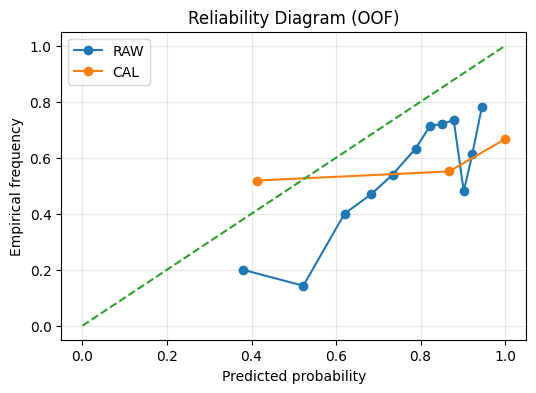

RAW ECE: 0.2185
CAL ECE: 0.2514


In [ ]:
# --- 8.1′ Reliability: RAW vs CAL (if both available) ---
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from sklearn.calibration import calibration_curve

assert 'y_oof' in globals() and 'p_oof' in globals(), "Run 11.3b″ to set RAW as current."
y_raw, p_raw = y_oof, p_oof

# If calibrated probs from earlier exist, compare; else plot RAW only
y_cal = globals().get("y_oof_cal", None)
p_cal = globals().get("p_oof_cal", None)

plt.figure(figsize=(6,4))
prob_true_raw, prob_pred_raw = calibration_curve(y_raw, p_raw, n_bins=12, strategy="quantile")
plt.plot(prob_pred_raw, prob_true_raw, marker='o', label="RAW")
if y_cal is not None and p_cal is not None and len(y_cal)==len(p_cal):
    prob_true_cal, prob_pred_cal = calibration_curve(y_cal, p_cal, n_bins=12, strategy="quantile")
    plt.plot(prob_pred_cal, prob_true_cal, marker='o', label="CAL")
plt.plot([0,1],[0,1],'--')
plt.xlabel("Predicted probability")
plt.ylabel("Empirical frequency")
plt.title("Reliability Diagram (OOF)")
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

ece_raw = float(np.mean(np.abs(prob_true_raw - prob_pred_raw)))
print(f"RAW ECE: {ece_raw:.4f}")
if y_cal is not None and p_cal is not None:
    ece_cal = float(np.mean(np.abs(prob_true_cal - prob_pred_cal)))
    print(f"CAL ECE: {ece_cal:.4f}")


# **12.1. Helpers (fallback backtest + signals backtest)**

In [ ]:
# --- 12.1 Backtest helpers for curves (global threshold & per-fold signals) ---
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Fallback: stats helper (if not defined in Section 9)
if 'performance_stats' not in globals():
    def performance_stats(equity_curve, freq=252):
        rets = np.log(equity_curve).diff().dropna()
        ann_ret = float(np.exp(rets.mean()*freq) - 1.0)
        ann_vol = float(rets.std(ddof=1) * np.sqrt(freq))
        sharpe = float(ann_ret / ann_vol) if ann_vol>0 else np.nan
        peak = equity_curve.cummax()
        dd = (equity_curve/peak - 1.0)
        mdd = float(dd.min())
        return {"CAGR": ann_ret, "Sharpe": sharpe, "MaxDD": mdd}

# Fallback: global-threshold backtest (if Section 9's backtest_from_oof isn't present)
if 'backtest_from_oof' not in globals():
    def backtest_from_oof(oof_df, prices, t_best, tc_bps=5, mode="long_only"):
        df = oof_df.merge(prices[[DATE_COL, 'logret']], on=DATE_COL, how='left').sort_values(DATE_COL)
        df['r1'] = df['logret'].shift(-1)
        df = df.dropna(subset=['r1']).reset_index(drop=True)

        if mode == "long_only":
            df['pos'] = (df['p_hat'] >= t_best).astype(int)
        elif mode == "long_short":
            df['pos'] = 0
            df.loc[df['p_hat'] >= t_best, 'pos'] = 1
            df.loc[df['p_hat'] <= (1 - t_best), 'pos'] = -1
        else:
            raise ValueError("Unknown mode")

        df['pos_shift'] = df['pos'].shift(1).fillna(0)
        df['turnover'] = (df['pos_shift'] - df['pos_shift'].shift(1)).abs().fillna(df['pos_shift'].abs())
        tc = (tc_bps / 1e4)
        df['ret_strategy'] = df['pos_shift'] * df['r1'] - df['turnover'] * tc
        df['equity'] = np.exp(df['ret_strategy'].cumsum())
        return df, performance_stats(df['equity'])

def backtest_from_signals(oof_dates, signals, prices, tc_bps=5):
    """
    Backtest from *precomputed* signals (0/1 long-only).
    signals: 1 = long, 0 = flat (same length as oof_dates)
    """
    sig_df = pd.DataFrame({DATE_COL: oof_dates, "signal": signals.astype(int)})
    df = sig_df.merge(prices[[DATE_COL, 'logret']], on=DATE_COL, how='left').sort_values(DATE_COL)
    df['r1'] = df['logret'].shift(-1)
    df = df.dropna(subset=['r1']).reset_index(drop=True)

    df['pos_shift'] = df['signal'].shift(1).fillna(0)
    df['turnover'] = (df['pos_shift'] - df['pos_shift'].shift(1)).abs().fillna(df['pos_shift'].abs())
    tc = (tc_bps / 1e4)
    df['ret_strategy'] = df['pos_shift'] * df['r1'] - df['turnover'] * tc
    df['equity'] = np.exp(df['ret_strategy'].cumsum())
    return df, performance_stats(df['equity'])


# **12.3. PnL curves using RAW OOF (global & per-fold thresholds)**

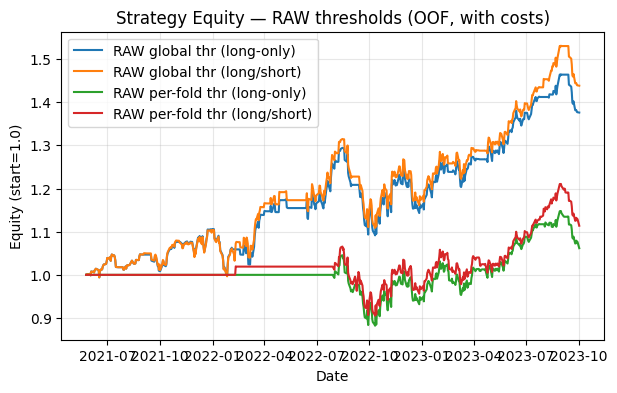

Stats (TC=5 bps)
RAW global — Long-only : {'CAGR': 0.1455, 'Sharpe': 0.9593, 'MaxDD': -0.1567}
RAW global — Long/Short: {'CAGR': 0.1673, 'Sharpe': 1.0894, 'MaxDD': -0.1567}
RAW per-fold — Long    : {'CAGR': 0.0258, 'Sharpe': 0.2139, 'MaxDD': -0.1563}
RAW per-fold — L/S     : {'CAGR': 0.047, 'Sharpe': 0.3703, 'MaxDD': -0.1504}


In [ ]:
# --- 12.4 Curves using RAW OOF (global thr & per-fold RAW thr) ---

assert 'oof_df' in globals() and 't_best' in globals() and 'thr_table' in globals()
assert 'prices' in globals() and 'logret' in prices.columns

TC_BPS = globals().get("TC_BPS", 5)

# Global threshold (RAW)
bt_raw_long, st_raw_long = backtest_from_oof(oof_df, prices, t_best=t_best, tc_bps=TC_BPS, mode="long_only")
bt_raw_ls,   st_raw_ls   = backtest_from_oof(oof_df, prices, t_best=t_best, tc_bps=TC_BPS, mode="long_short")

# Per-fold RAW thresholds → rebuild signals
thr_per_idx = np.full(len(y_final), np.nan)
for k, (tr, te) in enumerate(forward_splits(len(y_final), NUM_TRAIN, NUM_TEST, GAP), start=1):
    if k-1 < len(thr_table):
        thr_per_idx[te] = float(thr_table.iloc[k-1]['thr_val_raw'])
mask = ~np.isnan(thr_per_idx)
thr_oof = thr_per_idx[mask]

signals_long = (oof_df["p_hat"].values >= thr_oof).astype(int)
signals_ls   = np.zeros_like(signals_long)
signals_ls[oof_df["p_hat"].values >= thr_oof] = 1
signals_ls[oof_df["p_hat"].values <= (1.0 - thr_oof)] = -1

bt_val_long, st_val_long = backtest_from_signals(oof_df[DATE_COL].values, signals_long, prices, tc_bps=TC_BPS)
bt_val_ls,   st_val_ls   = backtest_from_signals(oof_df[DATE_COL].values, signals_ls,   prices, tc_bps=TC_BPS)

import matplotlib.pyplot as plt
plt.figure(figsize=(7,4))
plt.plot(bt_raw_long[DATE_COL], bt_raw_long['equity'], label="RAW global thr (long-only)")
plt.plot(bt_raw_ls[DATE_COL],   bt_raw_ls['equity'],   label="RAW global thr (long/short)")
plt.plot(bt_val_long[DATE_COL], bt_val_long['equity'], label="RAW per-fold thr (long-only)")
plt.plot(bt_val_ls[DATE_COL],   bt_val_ls['equity'],   label="RAW per-fold thr (long/short)")
plt.title("Strategy Equity — RAW thresholds (OOF, with costs)")
plt.xlabel(DATE_COL); plt.ylabel("Equity (start=1.0)")
plt.grid(True, alpha=0.3); plt.legend(); plt.show()

def _rs(d): return {k: round(v,4) for k,v in d.items()}
print(f"Stats (TC={TC_BPS} bps)")
print("RAW global — Long-only :", _rs(st_raw_long))
print("RAW global — Long/Short:", _rs(st_raw_ls))
print("RAW per-fold — Long    :", _rs(st_val_long))
print("RAW per-fold — L/S     :", _rs(st_val_ls))


# **12.5. Pick best band & min-hold, apply to signals, plot, and stash decision config**

Chosen decision settings: {'band': 0.0, 'min_hold': 5, 'thr_long': 0.675, 'thr_short': 0.325}


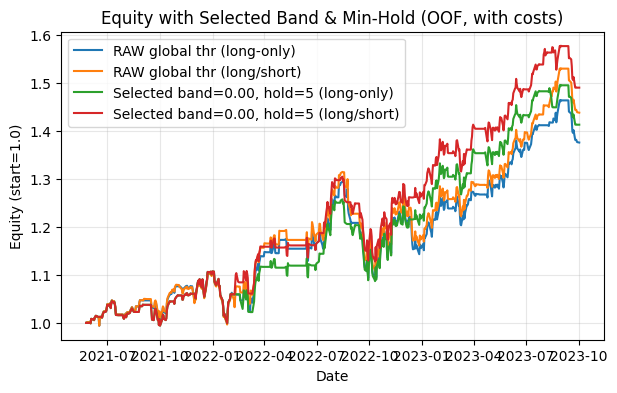

Stats (TC=5 bps)
Selected — Long-only : {'CAGR': 0.1586, 'Sharpe': 1.0997, 'MaxDD': -0.1356}
Selected — Long/Short: {'CAGR': 0.1852, 'Sharpe': 1.2746, 'MaxDD': -0.1356}
Saved decision policy → artifacts/decision/selected_policy.json


In [ ]:
# --- 12.6 Choose best band & min-hold, apply & plot, stash config ---

import numpy as np, pandas as pd, matplotlib.pyplot as plt, os, json

# Guards: needs RAW OOF from 11.3b″ and sweeper from 12.5 (or we'll run a default sweep)
assert 'oof_df' in globals() and 'p_oof' in globals() and 't_best' in globals(), "Run 11.3b″ first to set RAW OOF + t_best."
assert 'prices' in globals() and 'logret' in prices.columns, "Run 6.1 to build logret."
TC_BPS = globals().get("TC_BPS", 5)

# --- helpers (reuse if not defined) ---
def enforce_min_hold(signals: np.ndarray, min_hold: int) -> np.ndarray:
    if min_hold <= 1: return signals.astype(int)
    out = np.zeros_like(signals, dtype=int)
    cur, hold = 0, 0
    for i, s in enumerate(signals.astype(int)):
        if s == cur:
            hold += 1
        else:
            if hold >= min_hold:
                cur = s
                hold = 1
            else:
                hold += 1
        out[i] = cur
    return out

def backtest_signals_with_hold(dates, signals, prices, tc_bps=5):
    sig_df = pd.DataFrame({DATE_COL: dates, "signal": signals.astype(int)})
    df = sig_df.merge(prices[[DATE_COL,'logret']], on=DATE_COL, how='left').sort_values(DATE_COL)
    df['r1'] = df['logret'].shift(-1)
    df = df.dropna(subset=['r1']).reset_index(drop=True)
    df['pos_shift'] = df['signal'].shift(1).fillna(0)
    df['turnover']  = (df['pos_shift'] - df['pos_shift'].shift(1)).abs().fillna(df['pos_shift'].abs())
    tc = (tc_bps/1e4)
    df['ret_strategy'] = df['pos_shift']*df['r1'] - df['turnover']*tc
    df['equity'] = np.exp(df['ret_strategy'].cumsum())
    return df, performance_stats(df['equity'])

def sweep_band_and_hold(oof_df, base_thr, prices, tc_bps=5, bands=(0.0,0.02,0.04,0.06,0.08,0.10), holds=(1,3,5,10)):
    results = []
    p = oof_df["p_hat"].values
    d = oof_df[DATE_COL].values
    for b in bands:
        tL = min(0.99, base_thr + b)
        tS = max(0.01, 1.0 - base_thr - b)
        long_sig = (p >= tL).astype(int)
        ls_sig   = np.where(p >= tL, 1, np.where(p <= tS, -1, 0))
        for h in holds:
            _long = enforce_min_hold(long_sig, h)
            _ls   = enforce_min_hold(ls_sig,   h)
            _, stL = backtest_signals_with_hold(d, _long, prices, tc_bps=tc_bps)
            _, stS = backtest_signals_with_hold(d, _ls,   prices, tc_bps=tc_bps)
            results.append(dict(
                band=b, min_hold=h,
                thr_long=tL, thr_short=tS,
                long_CAGR=stL['CAGR'], long_Sharpe=stL['Sharpe'], long_MaxDD=stL['MaxDD'],
                ls_CAGR=stS['CAGR'],   ls_Sharpe=stS['Sharpe'],   ls_MaxDD=stS['MaxDD']
            ))
    return pd.DataFrame(results)

# Use existing sweep grid if available, otherwise run a default sweep
if 'grid' not in globals() or not isinstance(grid, pd.DataFrame) or grid.empty:
    grid = sweep_band_and_hold(oof_df, base_thr=t_best, prices=prices, tc_bps=TC_BPS)

# Selection rule: maximize long/short Sharpe, subject to a drawdown guard (e.g., MaxDD >= -35%)
DD_GUARD = -0.35
cand = grid.query("ls_MaxDD >= @DD_GUARD").copy()
if cand.empty:
    cand = grid.copy()  # fall back if all violate the guard
best = cand.sort_values(["ls_Sharpe","long_Sharpe"], ascending=False).iloc[0]

BAND   = float(best["band"])
MIN_H  = int(best["min_hold"])
THR_L  = float(best["thr_long"])
THR_S  = float(best["thr_short"])

print("Chosen decision settings:",
      {"band": BAND, "min_hold": MIN_H, "thr_long": round(THR_L,3), "thr_short": round(THR_S,3)})

# Build signals using chosen params
p = oof_df["p_hat"].values
d = oof_df[DATE_COL].values

sig_long = enforce_min_hold((p >= THR_L).astype(int), MIN_H)
sig_ls   = enforce_min_hold(np.where(p >= THR_L, 1, np.where(p <= THR_S, -1, 0)), MIN_H)

bt_long, st_long = backtest_signals_with_hold(d, sig_long, prices, tc_bps=TC_BPS)
bt_ls,   st_ls   = backtest_signals_with_hold(d, sig_ls,   prices, tc_bps=TC_BPS)

# Plot vs previous RAW globals (if available)
plt.figure(figsize=(7,4))
if 'bt_raw_long' in globals(): plt.plot(bt_raw_long[DATE_COL], bt_raw_long['equity'], label="RAW global thr (long-only)")
if 'bt_raw_ls'   in globals(): plt.plot(bt_raw_ls[DATE_COL],   bt_raw_ls['equity'],   label="RAW global thr (long/short)")
plt.plot(bt_long[DATE_COL], bt_long['equity'], label=f"Selected band={BAND:.2f}, hold={MIN_H} (long-only)")
plt.plot(bt_ls[DATE_COL],   bt_ls['equity'],   label=f"Selected band={BAND:.2f}, hold={MIN_H} (long/short)")
plt.title("Equity with Selected Band & Min-Hold (OOF, with costs)")
plt.xlabel(DATE_COL); plt.ylabel("Equity (start=1.0)")
plt.grid(True, alpha=0.3); plt.legend(); plt.show()

def _rs(d): return {k: round(v,4) for k,v in d.items()}
print(f"Stats (TC={TC_BPS} bps)")
print("Selected — Long-only :", _rs(st_long))
print("Selected — Long/Short:", _rs(st_ls))

# Stash a decision policy for Section 13
DECISION_RULE = dict(
    mode="long_short",          # change to "long_only" if you prefer
    base_threshold=float(t_best),
    band=BAND,
    min_hold=MIN_H,
    thr_long=THR_L,
    thr_short=THR_S,
    tc_bps=TC_BPS
)

# Save a small artifact for reproducibility
os.makedirs("artifacts/decision", exist_ok=True)
with open("artifacts/decision/selected_policy.json","w") as f:
    json.dump(DECISION_RULE, f, indent=2)
print("Saved decision policy → artifacts/decision/selected_policy.json")


# **13.1. Fit final model and save pipeline + config including decision policy**

In [ ]:
# --- 13.1 (updated) Final fit & save: model + config (with decision policy) ---

import os, json, joblib
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

assert 'study' in globals() and 'make_xgb' in globals()
assert 'X_final' in globals() and 'y_final' in globals()
assert 'DECISION_RULE' in globals(), "Run 12.6 to set DECISION_RULE."

best_params = study.best_params.copy()
numeric_cols = list(X_final.columns)

# class weight on full sample
pos = int(y_final.sum()); neg = int(len(y_final) - pos)
spw = (neg/pos) if pos>0 else 1.0

est_final = make_xgb(best_params); est_final.set_params(scale_pos_weight=spw)
pre = ColumnTransformer([("num", StandardScaler(), numeric_cols)], remainder="drop", verbose_feature_names_out=False)
final_pipe = Pipeline([("prep", pre), ("clf", est_final)])
final_pipe.fit(X_final, y_final)

os.makedirs("artifacts/final_model", exist_ok=True)
joblib.dump(final_pipe, "artifacts/final_model/fractal_xgb_pipeline.joblib")

config = dict(
    ticker=TICKER, start=START, end=END,
    best_params=best_params, scale_pos_weight=float(spw),
    features=numeric_cols, date_col=DATE_COL,
    decision=DECISION_RULE  # includes mode, base_threshold, band, min_hold, thr_long, thr_short, tc_bps
)
with open("artifacts/final_model/config.json", "w") as f:
    json.dump(config, f, indent=2)

print("Saved model → artifacts/final_model/fractal_xgb_pipeline.joblib")
print("Saved config → artifacts/final_model/config.json")


Saved model → artifacts/final_model/fractal_xgb_pipeline.joblib
Saved config → artifacts/final_model/config.json


# **13.2. Predict helper that respects the band (min-hold is enforced in your trading loop)**

In [ ]:
# --- 13.2 (updated) Predict helper using saved model & decision policy ---
import joblib, pandas as pd, json

def load_final_model():
    pipe = joblib.load("artifacts/final_model/fractal_xgb_pipeline.joblib")
    with open("artifacts/final_model/config.json") as f:
        cfg = json.load(f)
    return pipe, cfg

def predict_from_features_row(x_row: pd.Series):
    """
    x_row: single-row Series/DataFrame with columns identical to X_final.columns
    Decision: uses global banded thresholds. min_hold is *not* enforceable on a single row;
              apply it in your live trading loop over time.
    """
    pipe, cfg = load_final_model()
    feats = cfg["features"]
    proba = float(pipe.predict_proba(pd.DataFrame([x_row[c] for c in feats]).T)[:,1][0])

    rule = cfg["decision"]
    thr_long  = float(rule["thr_long"])
    thr_short = float(rule["thr_short"])
    mode = rule.get("mode","long_short")

    if mode == "long_only":
        decision = 1 if proba >= thr_long else 0
    else:
        decision = 1 if proba >= thr_long else (-1 if proba <= thr_short else 0)

    return {"prob": proba, "decision": decision, "thr_long": thr_long, "thr_short": thr_short}


# **14. Deployment smoke-test — reload model & do a quick predict**

In [ ]:
# --- 14.1 Reload final model + config, run a quick predict ---

import json, joblib, pandas as pd, numpy as np, os
from pathlib import Path

# Files from Sections 12.6 & 13.1 (updated)
model_path  = Path("artifacts/final_model/fractal_xgb_pipeline.joblib")
config_path = Path("artifacts/final_model/config.json")

assert model_path.exists() and config_path.exists(), "Run 13.1 (updated) to save the model & config."

pipe = joblib.load(model_path)
cfg  = json.load(open(config_path))
feat_cols = cfg["features"]
rule = cfg["decision"]

# Take the most recent feature row and score it
x_row = X_final.iloc[-1][feat_cols]
proba = float(pipe.predict_proba(pd.DataFrame([x_row], columns=feat_cols))[:,1][0])

# Apply banded thresholds (min_hold is enforced over time, not on a single row)
thr_long  = float(rule["thr_long"])
thr_short = float(rule["thr_short"])
mode      = rule.get("mode","long_short")

if mode == "long_only":
    decision = 1 if proba >= thr_long else 0
else:
    decision = 1 if proba >= thr_long else (-1 if proba <= thr_short else 0)

print({
    "prob": round(proba,6),
    "mode": mode,
    "thr_long": thr_long,
    "thr_short": thr_short,
    "one_step_decision": int(decision)
})


{'prob': 0.145136, 'mode': 'long_short', 'thr_long': 0.675, 'thr_short': 0.32499999999999996, 'one_step_decision': -1}


# **15. Live scoring + trading helper (applies band and min-hold)**

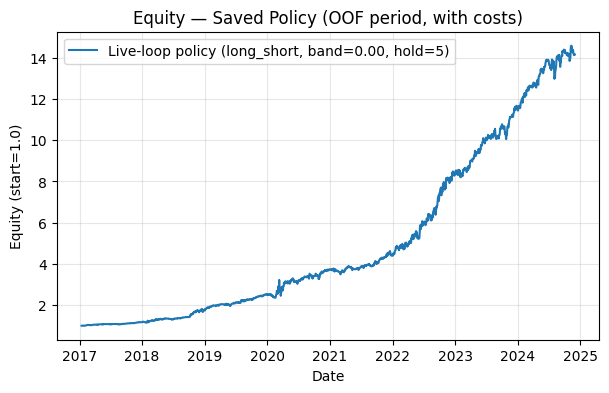

Policy: {'mode': 'long_short', 'thr_long': 0.675, 'thr_short': 0.32499999999999996, 'min_hold': 5, 'tc_bps': 5}
Stats: {'CAGR': 0.4015, 'Sharpe': 2.2488, 'MaxDD': -0.2381}


In [ ]:
# --- 15.1 Live trading loop using saved decision policy (band + min_hold) ---

import json, joblib, pandas as pd, numpy as np
import matplotlib.pyplot as plt

# Reuse helpers if present; otherwise define lightweight versions
if 'enforce_min_hold' not in globals():
    def enforce_min_hold(signals: np.ndarray, min_hold: int) -> np.ndarray:
        if min_hold <= 1: return signals.astype(int)
        out = np.zeros_like(signals, dtype=int); cur, hold = 0, 0
        for i, s in enumerate(signals.astype(int)):
            if s == cur:
                hold += 1
            else:
                if hold >= min_hold:
                    cur = s; hold = 1
                else:
                    hold += 1
            out[i] = cur
        return out

if 'backtest_signals_with_hold' not in globals():
    def backtest_signals_with_hold(dates, signals, prices, tc_bps=5):
        sig_df = pd.DataFrame({DATE_COL: dates, "signal": signals.astype(int)})
        df = sig_df.merge(prices[[DATE_COL,'logret']], on=DATE_COL, how='left').sort_values(DATE_COL)
        df['r1'] = df['logret'].shift(-1)
        df = df.dropna(subset=['r1']).reset_index(drop=True)
        df['pos_shift'] = df['signal'].shift(1).fillna(0)
        df['turnover']  = (df['pos_shift'] - df['pos_shift'].shift(1)).abs().fillna(df['pos_shift'].abs())
        tc = (tc_bps/1e4)
        df['ret_strategy'] = df['pos_shift']*df['r1'] - df['turnover']*tc
        df['equity'] = np.exp(df['ret_strategy'].cumsum())
        return df, performance_stats(df['equity'])

# Load model + policy
pipe = joblib.load("artifacts/final_model/fractal_xgb_pipeline.joblib")
cfg  = json.load(open("artifacts/final_model/config.json"))
feat_cols = cfg["features"]; rule = cfg["decision"]
mode = rule.get("mode","long_short"); min_hold = int(rule["min_hold"])
thr_long = float(rule["thr_long"]); thr_short = float(rule["thr_short"])
tc_bps = int(rule.get("tc_bps", 5))

# Build a scoring frame (date + features). Here we reuse df_all/X_final; in prod, replace with your live feature feed.
sc_df = df_all[[DATE_COL]].merge(X_final.reset_index(drop=True), left_index=True, right_index=True)
sc_df = sc_df.sort_values(DATE_COL).reset_index(drop=True)

# Predict probabilities
probs = pipe.predict_proba(sc_df[feat_cols])[:,1]
dates = sc_df[DATE_COL].values

# Apply policy (band + min_hold)
if mode == "long_only":
    raw_sig = (probs >= thr_long).astype(int)
else:
    raw_sig = np.zeros_like(probs, dtype=int)
    raw_sig[probs >= thr_long]  = 1
    raw_sig[probs <= thr_short] = -1

sig = enforce_min_hold(raw_sig, min_hold)

# Backtest with costs
bt, stats = backtest_signals_with_hold(dates, sig, prices, tc_bps=tc_bps)

# Plot
plt.figure(figsize=(7,4))
plt.plot(bt[DATE_COL], bt['equity'], label=f"Live-loop policy ({mode}, band={rule['band']:.02f}, hold={min_hold})")
plt.title("Equity — Saved Policy (OOF period, with costs)")
plt.xlabel(DATE_COL); plt.ylabel("Equity (start=1.0)")
plt.grid(True, alpha=0.3); plt.legend(); plt.show()

print("Policy:", dict(mode=mode, thr_long=thr_long, thr_short=thr_short, min_hold=min_hold, tc_bps=tc_bps))
print("Stats:", {k: round(v,4) for k,v in stats.items()})


# **16.1. Out-of-time holdout (train on early period, test on the last ~20%)**

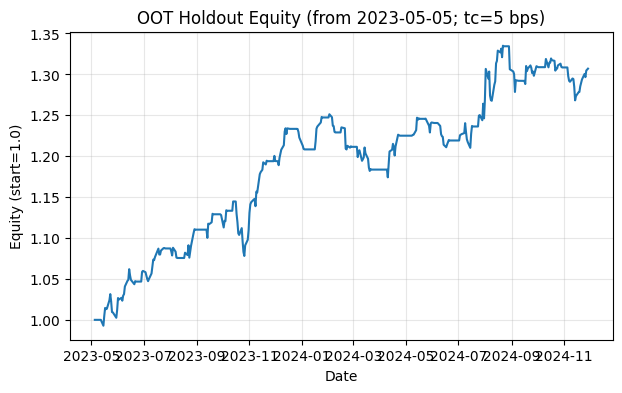

Holdout split date: 2023-05-05
Holdout stats: {'CAGR': 0.1863, 'Sharpe': 1.8972, 'MaxDD': -0.0616}


In [ ]:
# --- 16.1 OOT holdout backtest with saved policy ---

import numpy as np, pandas as pd, json, joblib, matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

assert 'df_all' in globals() and DATE_COL in df_all.columns
assert 'X_final' in globals() and 'y_final' in globals()
assert 'study' in globals() and 'make_xgb' in globals()
assert 'DECISION_RULE' in globals() and 'prices' in globals() and 'logret' in prices.columns

# choose split: last 20% as OOT test (or set a date with SPLIT_DATE="2022-01-01")
SPLIT_FRAC = 0.80
split_idx = int(len(df_all) * SPLIT_FRAC)
split_date = df_all[DATE_COL].iloc[split_idx]

train_mask = df_all[DATE_COL] < split_date
test_mask  = df_all[DATE_COL] >= split_date

X_tr, y_tr = X_final[train_mask.values], y_final[train_mask.values]
X_te       = X_final[test_mask.values]
dates_te   = df_all.loc[test_mask, DATE_COL].values

# class weight on training
pos, neg = int(y_tr.sum()), int(len(y_tr)-int(y_tr.sum()))
spw = (neg/pos) if pos>0 else 1.0

# fit final RAW pipeline on TRAIN only
best_params = study.best_params.copy()
pre = ColumnTransformer([("num", StandardScaler(), list(X_final.columns))], remainder="drop", verbose_feature_names_out=False)
est = make_xgb(best_params); est.set_params(scale_pos_weight=spw)
pipe = Pipeline([("prep", pre), ("clf", est)]).fit(X_tr, y_tr)

# score holdout
p_te = pipe.predict_proba(X_te)[:,1]

# build signals from saved policy
rule = DECISION_RULE
thr_long  = float(rule["thr_long"])
thr_short = float(rule["thr_short"])
min_hold  = int(rule["min_hold"])
tc_bps    = int(rule.get("tc_bps", 5))
mode      = rule.get("mode","long_short")

def enforce_min_hold(signals: np.ndarray, min_hold: int) -> np.ndarray:
    if min_hold <= 1: return signals.astype(int)
    out = np.zeros_like(signals, dtype=int); cur, hold = 0, 0
    for i, s in enumerate(signals.astype(int)):
        if s == cur: hold += 1
        else:
            if hold >= min_hold: cur = s; hold = 1
            else: hold += 1
        out[i] = cur
    return out

if mode == "long_only":
    raw_sig = (p_te >= thr_long).astype(int)
else:
    raw_sig = np.zeros_like(p_te, dtype=int)
    raw_sig[p_te >= thr_long]  = 1
    raw_sig[p_te <= thr_short] = -1

sig = enforce_min_hold(raw_sig, min_hold)

# backtest
def backtest_signals_with_hold(dates, signals, prices, tc_bps=5):
    sig_df = pd.DataFrame({DATE_COL: dates, "signal": signals.astype(int)})
    df = sig_df.merge(prices[[DATE_COL,'logret']], on=DATE_COL, how='left').sort_values(DATE_COL)
    df['r1'] = df['logret'].shift(-1)
    df = df.dropna(subset=['r1']).reset_index(drop=True)
    df['pos_shift'] = df['signal'].shift(1).fillna(0)
    df['turnover']  = (df['pos_shift'] - df['pos_shift'].shift(1)).abs().fillna(df['pos_shift'].abs())
    tc = (tc_bps/1e4)
    df['ret_strategy'] = df['pos_shift']*df['r1'] - df['turnover']*tc
    df['equity'] = np.exp(df['ret_strategy'].cumsum())
    return df

def performance_stats(equity_curve, freq=252):
    rets = np.log(equity_curve).diff().dropna()
    ann_ret = float(np.exp(rets.mean()*freq) - 1.0)
    ann_vol = float(rets.std(ddof=1) * np.sqrt(freq))
    sharpe = float(ann_ret / ann_vol) if ann_vol>0 else np.nan
    peak = equity_curve.cummax()
    dd = (equity_curve/peak - 1.0)
    mdd = float(dd.min())
    return {"CAGR": ann_ret, "Sharpe": sharpe, "MaxDD": mdd}

bt = backtest_signals_with_hold(dates_te, sig, prices, tc_bps=tc_bps)
stats = performance_stats(bt['equity'])

import matplotlib.pyplot as plt
plt.figure(figsize=(7,4))
plt.plot(bt[DATE_COL], bt['equity'])
plt.title(f"OOT Holdout Equity (from {str(split_date)[:10]}; tc={tc_bps} bps)")
plt.xlabel(DATE_COL); plt.ylabel("Equity (start=1.0)")
plt.grid(True, alpha=0.3); plt.show()

print("Holdout split date:", str(split_date)[:10])
print("Holdout stats:", {k: round(v,4) for k,v in stats.items()})


16.2. Transaction-cost sensitivity (0–25 bps)

In [ ]:
# 16.2 (fixed) — Transaction-cost sensitivity (0–25 bps)

import numpy as np, pandas as pd

assert 'oof_df' in globals() and 'prices' in globals(), "Need OOF predictions and price data."
rule = DECISION_RULE
thr_long, thr_short = float(rule["thr_long"]), float(rule["thr_short"])
min_hold = int(rule["min_hold"])
mode = rule.get("mode","long_short")

def mk_signals(probs, thrL, thrS, mode):
    if mode == "long_only":
        return (probs >= thrL).astype(int)
    s = np.zeros_like(probs, dtype=int)
    s[probs >= thrL] = 1
    s[probs <= thrS] = -1
    return s

# Reuse helpers if not in scope
if 'enforce_min_hold' not in globals():
    def enforce_min_hold(signals: np.ndarray, min_hold: int) -> np.ndarray:
        if min_hold <= 1: return signals.astype(int)
        out = np.zeros_like(signals, dtype=int); cur, hold = 0, 0
        for i, s in enumerate(signals.astype(int)):
            if s == cur: hold += 1
            else:
                if hold >= min_hold: cur = s; hold = 1
                else: hold += 1
            out[i] = cur
        return out

if 'backtest_signals_with_hold' not in globals():
    def backtest_signals_with_hold(dates, signals, prices, tc_bps=5):
        sig_df = pd.DataFrame({DATE_COL: dates, "signal": signals.astype(int)})
        df = sig_df.merge(prices[[DATE_COL,'logret']], on=DATE_COL, how='left').sort_values(DATE_COL)
        df['r1'] = df['logret'].shift(-1)
        df = df.dropna(subset=['r1']).reset_index(drop=True)
        df['pos_shift'] = df['signal'].shift(1).fillna(0)
        df['turnover']  = (df['pos_shift'] - df['pos_shift'].shift(1)).abs().fillna(df['pos_shift'].abs())
        tc = (tc_bps/1e4)
        df['ret_strategy'] = df['pos_shift']*df['r1'] - df['turnover']*tc
        df['equity'] = np.exp(df['ret_strategy'].cumsum())
        return df

if 'performance_stats' not in globals():
    def performance_stats(equity_curve, freq=252):
        rets = np.log(equity_curve).diff().dropna()
        ann_ret = float(np.exp(rets.mean()*freq) - 1.0)
        ann_vol = float(rets.std(ddof=1) * np.sqrt(freq))
        sharpe = float(ann_ret / ann_vol) if ann_vol>0 else np.nan
        peak = equity_curve.cummax()
        dd = (equity_curve/peak - 1.0)
        mdd = float(dd.min())
        return {"CAGR": ann_ret, "Sharpe": sharpe, "MaxDD": mdd}

def run_bt(dates, signals, costs):
    sig = enforce_min_hold(signals, min_hold)
    bt = backtest_signals_with_hold(dates, sig, prices, tc_bps=costs)
    return performance_stats(bt['equity'])

costs = [0, 5, 10, 25]
rows = []

# --- OOF block ---
dates_oof = oof_df[DATE_COL].values
probs_oof = oof_df["p_hat"].values
sig_oof   = mk_signals(probs_oof, thr_long, thr_short, mode)

for c in costs:
    st = run_bt(dates_oof, sig_oof, c)
    rows.append(dict(block="OOF", tc_bps=c, **{k: round(v,4) for k,v in st.items()}))

# --- OOT block (only if 16.1 ran) ---
if 'dates_te' in globals():
    if 'p_te' in globals():
        sig_oot = mk_signals(p_te, thr_long, thr_short, mode)
    elif 'sig' in globals() and len(sig) == len(globals().get('dates_te', [])):
        # reuse precomputed signals from 16.1 if available and aligned
        sig_oot = sig
    else:
        sig_oot = None

    if sig_oot is not None and len(sig_oot) == len(dates_te):
        for c in costs:
            st = run_bt(dates_te, sig_oot, c)
            rows.append(dict(block="OOT", tc_bps=c, **{k: round(v,4) for k,v in st.items()}))
    else:
        print("Skipping OOT cost sweep: missing or misaligned (dates_te, p_te/sig).")

df_cost = pd.DataFrame(rows)
display(df_cost)


,block,tc_bps,CAGR,Sharpe,MaxDD
0,OOF,0,0.1994,1.3724,-0.1338
1,OOF,5,0.1852,1.2746,-0.1356
2,OOF,10,0.1711,1.1777,-0.1373
3,OOF,25,0.1300,0.8926,-0.1436
4,OOT,0,0.2096,2.1350,-0.0588
5,OOT,5,0.1863,1.8972,-0.0616
6,OOT,10,0.1634,1.6622,-0.0644
7,OOT,25,0.0974,0.9809,-0.0741


# **17.1. Baseline vs Tuned (robust OOF comparison at best threshold)**

**Loads what it can find:**


**baseline:**
artifacts/oof_predictions_baseline.csv





**tuned_raw:**
artifacts/raw_valthr/oof_predictions_raw.csv




**tuned_cal:**
artifacts/tuned_mcc_valthr/oof_predictions_calibrated.csv




**tuned_misc (optional legacy):**
artifacts/oof_predictions_tuned.csv


**current_in_memory:**
from y_oof, p_oof (whatever you ran last)




Computes each variant’s best MCC threshold and metrics.

In [ ]:
# --- 17.1 Baseline vs Tuned: OOF metrics at best threshold (robust loader) ---

import os, json, numpy as np, pandas as pd
from sklearn.metrics import roc_auc_score, average_precision_score, brier_score_loss, matthews_corrcoef
from IPython.display import display

def try_load_csv(path):
    return pd.read_csv(path) if os.path.exists(path) else None

def best_thr_mcc(y, p):
    grid = np.linspace(0.05, 0.95, 37)
    best_t, best_m = 0.5, -1
    for t in grid:
        m = matthews_corrcoef(y, (p>=t).astype(int))
        if m>best_m:
            best_t, best_m = float(t), float(m)
    return best_t, best_m

def oof_scores(y, p, thr):
    return dict(
        roc_auc = float(roc_auc_score(y,p)),
        pr_auc  = float(average_precision_score(y,p)),
        brier   = float(brier_score_loss(y,p)),
        mcc     = float(matthews_corrcoef(y,(p>=thr).astype(int))),
        thr     = float(thr),
        n       = int(len(y))
    )

# Candidate sources
cands = []

# 1) Baseline (if saved)
df_base = try_load_csv("artifacts/oof_predictions_baseline.csv")
if df_base is not None and {'y_true','p_hat'}.issubset(df_base.columns):
    yb, pb = df_base['y_true'].values, df_base['p_hat'].values
    cands.append(("baseline", yb, pb, df_base))

# 2) Tuned (raw)
df_raw = try_load_csv("artifacts/raw_valthr/oof_predictions_raw.csv")
if df_raw is not None and {'y_true','p_hat'}.issubset(df_raw.columns):
    yr, pr = df_raw['y_true'].values, df_raw['p_hat'].values
    cands.append(("tuned_raw", yr, pr, df_raw))

# 3) Tuned (calibrated)
df_cal = try_load_csv("artifacts/tuned_mcc_valthr/oof_predictions_calibrated.csv")
if df_cal is not None and {'y_true','p_hat'}.issubset(df_cal.columns):
    yc, pc = df_cal['y_true'].values, df_cal['p_hat'].values
    cands.append(("tuned_cal", yc, pc, df_cal))

# 4) Legacy tuned (if any)
df_tuned_misc = try_load_csv("artifacts/oof_predictions_tuned.csv")
if df_tuned_misc is not None and {'y_true','p_hat'}.issubset(df_tuned_misc.columns):
    yt, pt = df_tuned_misc['y_true'].values, df_tuned_misc['p_hat'].values
    cands.append(("tuned_misc", yt, pt, df_tuned_misc))

# 5) Current in-memory (whatever you last set y_oof/p_oof to)
if 'y_oof' in globals() and 'p_oof' in globals():
    cands.append(("current_in_memory", np.asarray(y_oof), np.asarray(p_oof), None))

rows = []
for name, yv, pv, df in cands:
    if len(yv) != len(pv) or len(yv) == 0:
        continue
    t_best, m_best = best_thr_mcc(yv, pv)
    s_best = oof_scores(yv, pv, t_best)
    s_05   = oof_scores(yv, pv, 0.5)
    rows.append(dict(
        variant=name,
        **{f"best_{k}": round(v,4) if isinstance(v,(int,float,np.floating)) else v for k,v in s_best.items()},
        **{f"thr0p5_{k}": round(v,4) if isinstance(v,(int,float,np.floating)) else v for k,v in s_05.items()}
    ))

df_cmp = pd.DataFrame(rows)
if not df_cmp.empty:
    display(df_cmp.sort_values("best_mcc", ascending=False))
else:
    print("No OOF sources found. Make sure artifacts exist or y_oof/p_oof are in memory.")


,variant,best_roc_auc,best_pr_auc,best_brier,best_mcc,best_thr,best_n,thr0p5_roc_auc,thr0p5_pr_auc,thr0p5_brier,thr0p5_mcc,thr0p5_thr,thr0p5_n
1,tuned_raw,0.6813,0.6799,0.2676,0.3484,0.675,594,0.6813,0.6799,0.2676,0.2424,0.5,594
3,current_in_memory,0.6813,0.6799,0.2676,0.3484,0.675,594,0.6813,0.6799,0.2676,0.2424,0.5,594
0,baseline,0.5071,0.6108,0.2660,0.2080,0.725,594,0.5071,0.6108,0.2660,0.0000,0.5,594
2,tuned_cal,0.4988,0.5638,0.2747,0.0790,0.725,594,0.4988,0.5638,0.2747,0.0000,0.5,594


# **17.2. PnL sanity across variants at their best thresholds**

Uses backtest_from_oof if present (from Section 12.1), otherwise defines a lightweight fallback.

Compares long-only and long/short with a given cost.

In [ ]:
# --- 17.2 (final fix) — PnL sanity across variants (best thresholds), dtype-safe & load-safe ---

import os, numpy as np, pandas as pd
from sklearn.metrics import matthews_corrcoef

TC_BPS = globals().get("TC_BPS", 5)

def _normalize_dt(s):
    c = pd.to_datetime(s, errors="coerce")
    try: return c.dt.tz_localize(None)
    except Exception: return c

def performance_stats(equity_curve, freq=252):
    rets = np.log(equity_curve).diff().dropna()
    ann_ret = float(np.exp(rets.mean()*freq) - 1.0)
    ann_vol = float(rets.std(ddof=1) * np.sqrt(freq))
    sharpe = float(ann_ret / ann_vol) if ann_vol>0 else np.nan
    peak = equity_curve.cummax()
    dd = (equity_curve/peak - 1.0)
    mdd = float(dd.min())
    return {"CAGR": ann_ret, "Sharpe": sharpe, "MaxDD": mdd}

def backtest_from_oof(oof_df, prices, t_best, tc_bps=5, mode="long_only"):
    o = oof_df.copy()
    px = prices[[DATE_COL, 'logret']].copy()
    o[DATE_COL]  = _normalize_dt(o[DATE_COL])
    px[DATE_COL] = _normalize_dt(px[DATE_COL])
    o = o.dropna(subset=[DATE_COL]).drop_duplicates(subset=[DATE_COL])
    px= px.dropna(subset=[DATE_COL]).drop_duplicates(subset=[DATE_COL])

    df = o.merge(px, on=DATE_COL, how='left').sort_values(DATE_COL)
    df['r1'] = df['logret'].shift(-1)
    df = df.dropna(subset=['r1']).reset_index(drop=True)

    if mode == "long_only":
        df['pos'] = (df['p_hat'] >= t_best).astype(int)
    elif mode == "long_short":
        df['pos'] = 0
        df.loc[df['p_hat'] >= t_best, 'pos'] = 1
        df.loc[df['p_hat'] <= (1 - t_best), 'pos'] = -1
    else:
        raise ValueError("Unknown mode")

    df['pos_shift'] = df['pos'].shift(1).fillna(0)
    df['turnover']  = (df['pos_shift'] - df['pos_shift'].shift(1)).abs().fillna(df['pos_shift'].abs())
    tc = (tc_bps / 1e4)
    df['ret_strategy'] = df['pos_shift'] * df['r1'] - df['turnover'] * tc
    df['equity'] = np.exp(df['ret_strategy'].cumsum())
    return df, performance_stats(df['equity'])

def best_thr_mcc(y, p):
    grid = np.linspace(0.05, 0.95, 37)
    best_t, best_m = 0.5, -1
    for t in grid:
        m = matthews_corrcoef(y, (p>=t).astype(int))
        if m > best_m: best_t, best_m = float(t), float(m)
    return best_t, best_m

def _try_load(path):
    return pd.read_csv(path) if os.path.exists(path) else None

def pick_df(name, path):
    obj = globals().get(name, None)
    if isinstance(obj, pd.DataFrame) and not obj.empty:
        return obj
    return _try_load(path)

# Load candidates safely (no ambiguous DataFrame truth checks)
df_base = pick_df("df_base", "artifacts/oof_predictions_baseline.csv")
df_raw  = pick_df("df_raw",  "artifacts/raw_valthr/oof_predictions_raw.csv")
df_cal  = pick_df("df_cal",  "artifacts/tuned_mcc_valthr/oof_predictions_calibrated.csv")
df_misc = pick_df("df_tuned_misc", "artifacts/oof_predictions_tuned.csv")

def pnl_for_variant(name, df_src, y, p):
    # choose dates: prefer provided df_src dates; otherwise borrow from current oof_df
    if df_src is not None and DATE_COL in df_src.columns:
        dates = df_src[DATE_COL].values
    else:
        assert 'oof_df' in globals() and DATE_COL in oof_df.columns, f"{name}: missing dates; need oof_df."
        dates = oof_df[DATE_COL].values

    # length guard: trim to common tail if mismatch
    n = min(len(dates), len(y), len(p))
    dates, y, p = dates[-n:], y[-n:], p[-n:]

    t, _ = best_thr_mcc(y, p)
    oof_local = pd.DataFrame({DATE_COL: dates, "y_true": y, "p_hat": p})
    btL, stL = backtest_from_oof(oof_local, prices, t_best=t, tc_bps=TC_BPS, mode="long_only")
    btS, stS = backtest_from_oof(oof_local, prices, t_best=t, tc_bps=TC_BPS, mode="long_short")
    return dict(
        variant=name, thr_best=round(t,3),
        long_CAGR=round(stL['CAGR'],4), long_Sharpe=round(stL['Sharpe'],4), long_MaxDD=round(stL['MaxDD'],4),
        ls_CAGR=round(stS['CAGR'],4),   ls_Sharpe=round(stS['Sharpe'],4),   ls_MaxDD=round(stS['MaxDD'],4),
    )

rows = []
for name, df_src in [("baseline", df_base), ("tuned_raw", df_raw), ("tuned_cal", df_cal), ("tuned_misc", df_misc)]:
    if df_src is not None and {'y_true','p_hat'}.issubset(df_src.columns):
        yv, pv = df_src['y_true'].values, df_src['p_hat'].values
        rows.append(pnl_for_variant(name, df_src, yv, pv))

if 'y_oof' in globals() and 'p_oof' in globals():
    rows.append(pnl_for_variant("current_in_memory", globals().get("oof_df", None),
                                np.asarray(y_oof), np.asarray(p_oof)))

df_pnl_cmp = pd.DataFrame(rows)
display(df_pnl_cmp.sort_values("ls_Sharpe", ascending=False) if not df_pnl_cmp.empty else pd.DataFrame([{"note":"No variants available"}]))


,variant,thr_best,long_CAGR,long_Sharpe,long_MaxDD,ls_CAGR,ls_Sharpe,ls_MaxDD
1,tuned_raw,0.675,0.1455,0.9593,-0.1567,0.1673,1.0894,-0.1567
3,current_in_memory,0.675,0.1455,0.9593,-0.1567,0.1673,1.0894,-0.1567
0,baseline,0.725,-0.0090,-0.1091,-0.1514,-0.0090,-0.1091,-0.1514
2,tuned_cal,0.725,-0.0321,-0.3054,-0.1533,-0.0321,-0.3054,-0.1533


# **17.F1. Load variants & compute OOF metrics at each variant’s best MCC threshold**

In [ ]:
# --- 17.F1 Baseline vs Tuned: OOF metrics @ best threshold (robust loader) ---

import os, json, numpy as np, pandas as pd
from pathlib import Path
from sklearn.metrics import roc_auc_score, average_precision_score, brier_score_loss, matthews_corrcoef

ARTDIR = Path("artifacts/comparison"); ARTDIR.mkdir(parents=True, exist_ok=True)
DATE_COL = globals().get("DATE_COL", "Date")

def try_load(path):
    return pd.read_csv(path) if Path(path).exists() else None

def best_thr_mcc(y, p):
    grid = np.linspace(0.05, 0.95, 37)
    best_t, best_m = 0.5, -1.0
    for t in grid:
        m = matthews_corrcoef(y, (p >= t).astype(int))
        if m > best_m:
            best_t, best_m = float(t), float(m)
    return best_t, best_m

def oof_scores(y, p, thr):
    return dict(
        roc_auc = float(roc_auc_score(y, p)),
        pr_auc  = float(average_precision_score(y, p)),
        brier   = float(brier_score_loss(y, p)),
        mcc     = float(matthews_corrcoef(y, (p >= thr).astype(int))),
        thr     = float(thr),
        n       = int(len(y)),
    )

# Candidate OOF sources
sources = []

# 1) Baseline (if saved)
df_base = try_load("artifacts/oof_predictions_baseline.csv")
if df_base is not None and {'y_true','p_hat'}.issubset(df_base.columns):
    sources.append(("baseline", df_base))

# 2) Tuned RAW (your best)
df_raw = try_load("artifacts/raw_valthr/oof_predictions_raw.csv")
if df_raw is not None and {'y_true','p_hat'}.issubset(df_raw.columns):
    sources.append(("tuned_raw", df_raw))

# 3) Tuned calibrated (for reference)
df_cal = try_load("artifacts/tuned_mcc_valthr/oof_predictions_calibrated.csv")
if df_cal is not None and {'y_true','p_hat'}.issubset(df_cal.columns):
    sources.append(("tuned_cal", df_cal))

# 4) Legacy tuned (optional)
df_misc = try_load("artifacts/oof_predictions_tuned.csv")
if df_misc is not None and {'y_true','p_hat'}.issubset(df_misc.columns):
    sources.append(("tuned_misc", df_misc))

# 5) Current in-memory (whatever you last set y_oof/p_oof to)
if 'y_oof' in globals() and 'p_oof' in globals():
    if 'oof_df' in globals() and DATE_COL in oof_df.columns:
        df_cur = pd.DataFrame({DATE_COL: oof_df[DATE_COL].values, "y_true": np.asarray(y_oof), "p_hat": np.asarray(p_oof)})
    else:
        # fallback: no dates; we'll borrow from prices later for PnL
        df_cur = pd.DataFrame({"y_true": np.asarray(y_oof), "p_hat": np.asarray(p_oof)})
    sources.append(("current_in_memory", df_cur))

# --- Build metric table ---
metric_rows = []
for name, df_src in sources:
    if not {'y_true','p_hat'}.issubset(df_src.columns):
        continue
    y = df_src['y_true'].values
    p = df_src['p_hat'].values
    n = min(len(y), len(p))
    if n == 0:
        continue
    y, p = y[-n:], p[-n:]
    t_best, _ = best_thr_mcc(y, p)
    s_best = oof_scores(y, p, t_best)
    s_05   = oof_scores(y, p, 0.5)
    metric_rows.append({
        "variant": name,
        "best_thr": round(s_best['thr'], 3),
        "best_roc_auc": round(s_best['roc_auc'], 4),
        "best_pr_auc": round(s_best['pr_auc'], 4),
        "best_brier": round(s_best['brier'], 5),
        "best_mcc": round(s_best['mcc'], 4),
        "thr0p5_roc_auc": round(s_05['roc_auc'], 4),
        "thr0p5_pr_auc": round(s_05['pr_auc'], 4),
        "thr0p5_brier": round(s_05['brier'], 5),
        "thr0p5_mcc": round(s_05['mcc'], 4),
        "n": s_best['n']
    })

df_metrics = pd.DataFrame(metric_rows).sort_values("best_mcc", ascending=False)
display(df_metrics)

# Save
df_metrics.to_csv(ARTDIR/"oof_metrics_best_vs_05.csv", index=False)
with open(ARTDIR/"oof_metrics_best_vs_05.json","w") as f:
    json.dump(df_metrics.to_dict(orient="records"), f, indent=2)

print("Saved OOF metrics to:", ARTDIR/"oof_metrics_best_vs_05.csv")


,variant,best_thr,best_roc_auc,best_pr_auc,best_brier,best_mcc,thr0p5_roc_auc,thr0p5_pr_auc,thr0p5_brier,thr0p5_mcc,n
1,tuned_raw,0.675,0.6813,0.6799,0.26761,0.3484,0.6813,0.6799,0.26761,0.2424,594
3,current_in_memory,0.675,0.6813,0.6799,0.26761,0.3484,0.6813,0.6799,0.26761,0.2424,594
0,baseline,0.725,0.5071,0.6108,0.26596,0.2080,0.5071,0.6108,0.26596,0.0000,594
2,tuned_cal,0.725,0.4988,0.5638,0.27471,0.0790,0.4988,0.5638,0.27471,0.0000,594


Saved OOF metrics to: artifacts/comparison/oof_metrics_best_vs_05.csv


# **17.F2. PnL at each variant’s best threshold (long-only & long/short), dtype-safe dates**

In [ ]:
# --- 17.F2 PnL at best threshold for each variant (robust date handling) ---

import os, json, numpy as np, pandas as pd
from pathlib import Path

assert 'prices' in globals(), "Missing `prices` in memory. Run your data loading cell first."
DATE_COL = globals().get("DATE_COL", "Date")
TC_BPS   = int(globals().get("TC_BPS", 5))
ARTDIR   = Path("artifacts/comparison"); ARTDIR.mkdir(parents=True, exist_ok=True)

def _norm_dt(s):
    c = pd.to_datetime(s, errors="coerce")
    try: return c.dt.tz_localize(None)
    except Exception: return c

# Ensure log returns exist
if 'logret' not in prices.columns:
    if 'Close' in prices.columns:
        prices = prices.copy()
        prices['logret'] = np.log(prices['Close']).diff()
    else:
        raise ValueError("`prices` must include 'logret' or 'Close'.")

# Reload the same sources as in 17.F1
def try_load(path):
    return pd.read_csv(path) if Path(path).exists() else None

srcs = []
for name, path in [
    ("baseline", "artifacts/oof_predictions_baseline.csv"),
    ("tuned_raw", "artifacts/raw_valthr/oof_predictions_raw.csv"),
    ("tuned_cal", "artifacts/tuned_mcc_valthr/oof_predictions_calibrated.csv"),
    ("tuned_misc","artifacts/oof_predictions_tuned.csv"),
]:
    df = try_load(path)
    if df is not None and {'y_true','p_hat'}.issubset(df.columns):
        srcs.append((name, df))

# Add current in-memory if available
if 'y_oof' in globals() and 'p_oof' in globals():
    if 'oof_df' in globals() and DATE_COL in oof_df.columns:
        df_cur = pd.DataFrame({DATE_COL: oof_df[DATE_COL].values, "y_true": np.asarray(y_oof), "p_hat": np.asarray(p_oof)})
    else:
        # we'll borrow dates from prices (tail match)
        k = len(y_oof)
        d0 = prices[DATE_COL].iloc[-k:].values if len(prices)>=k else np.arange(k)
        df_cur = pd.DataFrame({DATE_COL: d0, "y_true": np.asarray(y_oof), "p_hat": np.asarray(p_oof)})
    srcs.append(("current_in_memory", df_cur))

from sklearn.metrics import matthews_corrcoef
def best_thr_mcc(y, p):
    grid = np.linspace(0.05, 0.95, 37)
    best_t, best_m = 0.5, -1.0
    for t in grid:
        m = matthews_corrcoef(y, (p >= t).astype(int))
        if m > best_m:
            best_t, best_m = float(t), float(m)
    return best_t, best_m

def performance_stats(equity_curve, freq=252):
    rets = np.log(equity_curve).diff().dropna()
    ann_ret = float(np.exp(rets.mean()*freq) - 1.0)
    ann_vol = float(rets.std(ddof=1) * np.sqrt(freq))
    sharpe  = float(ann_ret / ann_vol) if ann_vol > 0 else np.nan
    peak    = equity_curve.cummax()
    dd      = (equity_curve/peak - 1.0)
    mdd     = float(dd.min())
    return {"CAGR": ann_ret, "Sharpe": sharpe, "MaxDD": mdd}

def backtest_from_oof(oof_df, prices, t_best, tc_bps=5, mode="long_only"):
    o = oof_df.copy()
    px = prices[[DATE_COL, 'logret']].copy()
    o[DATE_COL]  = _norm_dt(o[DATE_COL])
    px[DATE_COL] = _norm_dt(px[DATE_COL])
    o  = o.dropna(subset=[DATE_COL]).drop_duplicates(subset=[DATE_COL])
    px = px.dropna(subset=[DATE_COL]).drop_duplicates(subset=[DATE_COL])

    df = o.merge(px, on=DATE_COL, how='left').sort_values(DATE_COL)
    df['r1'] = df['logret'].shift(-1)
    df = df.dropna(subset=['r1']).reset_index(drop=True)

    if mode == "long_only":
        df['pos'] = (df['p_hat'] >= t_best).astype(int)
    elif mode == "long_short":
        df['pos'] = 0
        df.loc[df['p_hat'] >= t_best, 'pos'] = 1
        df.loc[df['p_hat'] <= (1 - t_best), 'pos'] = -1
    else:
        raise ValueError("Unknown mode")

    df['pos_shift'] = df['pos'].shift(1).fillna(0)
    df['turnover']  = (df['pos_shift'] - df['pos_shift'].shift(1)).abs().fillna(df['pos_shift'].abs())
    tc = (tc_bps / 1e4)
    df['ret_strategy'] = df['pos_shift'] * df['r1'] - df['turnover'] * tc
    df['equity'] = np.exp(df['ret_strategy'].cumsum())
    return df, performance_stats(df['equity'])

# Compute PnL blocks
pnl_rows = []
for name, df_src in srcs:
    if not {'y_true','p_hat', DATE_COL}.issubset(df_src.columns):
        # skip if dates missing (shouldn't happen after 17.F1 paths)
        continue
    y = df_src['y_true'].values
    p = df_src['p_hat'].values
    d = df_src[DATE_COL].values
    n = min(len(y), len(p), len(d))
    if n == 0:
        continue
    y, p, d = y[-n:], p[-n:], d[-n:]

    t_best, _ = best_thr_mcc(y, p)
    oof_local = pd.DataFrame({DATE_COL: d, "y_true": y, "p_hat": p})

    btL, stL = backtest_from_oof(oof_local, prices, t_best=t_best, tc_bps=TC_BPS, mode="long_only")
    btS, stS = backtest_from_oof(oof_local, prices, t_best=t_best, tc_bps=TC_BPS, mode="long_short")

    pnl_rows.append(dict(
        variant=name, thr_best=round(t_best,3), tc_bps=TC_BPS,
        long_CAGR=round(stL['CAGR'],4), long_Sharpe=round(stL['Sharpe'],4), long_MaxDD=round(stL['MaxDD'],4),
        ls_CAGR=round(stS['CAGR'],4),   ls_Sharpe=round(stS['Sharpe'],4),   ls_MaxDD=round(stS['MaxDD'],4),
    ))

df_pnl = pd.DataFrame(pnl_rows).sort_values("ls_Sharpe", ascending=False)
display(df_pnl)

# Save
df_pnl.to_csv(ARTDIR/"pnl_at_best_threshold.csv", index=False)
with open(ARTDIR/"pnl_at_best_threshold.json","w") as f:
    json.dump(df_pnl.to_dict(orient="records"), f, indent=2)

print("Saved PnL table to:", ARTDIR/"pnl_at_best_threshold.csv")


,variant,thr_best,tc_bps,long_CAGR,long_Sharpe,long_MaxDD,ls_CAGR,ls_Sharpe,ls_MaxDD
1,tuned_raw,0.675,5,0.1455,0.9593,-0.1567,0.1673,1.0894,-0.1567
3,current_in_memory,0.675,5,0.1455,0.9593,-0.1567,0.1673,1.0894,-0.1567
0,baseline,0.725,5,-0.0090,-0.1091,-0.1514,-0.0090,-0.1091,-0.1514
2,tuned_cal,0.725,5,-0.0321,-0.3054,-0.1533,-0.0321,-0.3054,-0.1533


Saved PnL table to: artifacts/comparison/pnl_at_best_threshold.csv


# **18.1. OOF stability by time (metrics & PnL by year and quarter)**

In [ ]:
# --- 18.1 OOF stability by time: per-year & per-quarter metrics + PnL ---

import numpy as np, pandas as pd, os, json, matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, average_precision_score, brier_score_loss, matthews_corrcoef
from pathlib import Path

# Guards & fallbacks
assert 'oof_df' in globals() and {'y_true','p_hat'}.issubset(oof_df.columns), "Need OOF oof_df with y_true & p_hat."
assert 'prices' in globals() and 'logret' in prices.columns, "Need prices with logret (run Section 6.1)."
DATE_COL = globals().get("DATE_COL", "Date")
TC_BPS   = int(globals().get("TC_BPS", 5))

if 'performance_stats' not in globals():
    def performance_stats(equity_curve, freq=252):
        rets = np.log(equity_curve).diff().dropna()
        ann_ret = float(np.exp(rets.mean()*freq) - 1.0)
        ann_vol = float(rets.std(ddof=1) * np.sqrt(freq))
        sharpe = float(ann_ret / ann_vol) if ann_vol>0 else np.nan
        peak = equity_curve.cummax()
        dd = (equity_curve/peak - 1.0)
        mdd = float(dd.min())
        return {"CAGR": ann_ret, "Sharpe": sharpe, "MaxDD": mdd}

if 'backtest_from_oof' not in globals():
    def backtest_from_oof(oof_df, prices, t_best, tc_bps=5, mode="long_only"):
        df = oof_df.merge(prices[[DATE_COL, 'logret']], on=DATE_COL, how='left').sort_values(DATE_COL)
        df['r1'] = df['logret'].shift(-1)
        df = df.dropna(subset=['r1']).reset_index(drop=True)
        if mode == "long_only":
            df['pos'] = (df['p_hat'] >= t_best).astype(int)
        elif mode == "long_short":
            df['pos'] = 0
            df.loc[df['p_hat'] >= t_best, 'pos'] = 1
            df.loc[df['p_hat'] <= (1 - t_best), 'pos'] = -1
        else:
            raise ValueError("Unknown mode")
        df['pos_shift'] = df['pos'].shift(1).fillna(0)
        df['turnover']  = (df['pos_shift'] - df['pos_shift'].shift(1)).abs().fillna(df['pos_shift'].abs())
        tc = (tc_bps/1e4)
        df['ret_strategy'] = df['pos_shift']*df['r1'] - df['turnover']*tc
        df['equity'] = np.exp(df['ret_strategy'].cumsum())
        return df, performance_stats(df['equity'])

def metrics_at_thr(y, p, thr):
    return dict(
        roc_auc = float(roc_auc_score(y,p)),
        pr_auc  = float(average_precision_score(y,p)),
        brier   = float(brier_score_loss(y,p)),
        mcc     = float(matthews_corrcoef(y,(p>=thr).astype(int)))
    )

# Prep
oo = oof_df.copy()
oo[DATE_COL] = pd.to_datetime(oo[DATE_COL])
oo['year']   = oo[DATE_COL].dt.year
oo['q']      = oo[DATE_COL].dt.to_period('Q').astype(str)

thr = float(globals().get("t_best", 0.5))  # use your global best

rows_y, rows_q = [], []
for y, g in oo.groupby('year'):
    m = metrics_at_thr(g['y_true'].values, g['p_hat'].values, thr)
    btL, stL = backtest_from_oof(g[[DATE_COL, 'y_true','p_hat']], prices, thr, TC_BPS, mode="long_only")
    btS, stS = backtest_from_oof(g[[DATE_COL, 'y_true','p_hat']], prices, thr, TC_BPS, mode="long_short")
    rows_y.append(dict(period=str(y), n=len(g), **{f"metric_{k}":round(v,4) for k,v in m.items()},
                       long_CAGR=round(stL['CAGR'],4), long_Sharpe=round(stL['Sharpe'],4), long_MaxDD=round(stL['MaxDD'],4),
                       ls_CAGR=round(stS['CAGR'],4),   ls_Sharpe=round(stS['Sharpe'],4),   ls_MaxDD=round(stS['MaxDD'],4)))

for q, g in oo.groupby('q'):
    m = metrics_at_thr(g['y_true'].values, g['p_hat'].values, thr)
    btL, stL = backtest_from_oof(g[[DATE_COL, 'y_true','p_hat']], prices, thr, TC_BPS, mode="long_only")
    btS, stS = backtest_from_oof(g[[DATE_COL, 'y_true','p_hat']], prices, thr, TC_BPS, mode="long_short")
    rows_q.append(dict(period=str(q), n=len(g), **{f"metric_{k}":round(v,4) for k,v in m.items()},
                       long_CAGR=round(stL['CAGR'],4), long_Sharpe=round(stL['Sharpe'],4), long_MaxDD=round(stL['MaxDD'],4),
                       ls_CAGR=round(stS['CAGR'],4),   ls_Sharpe=round(stS['Sharpe'],4),   ls_MaxDD=round(stS['MaxDD'],4)))

df_year   = pd.DataFrame(rows_y).sort_values('period')
df_quarter= pd.DataFrame(rows_q).sort_values('period')

Path("artifacts/checks").mkdir(parents=True, exist_ok=True)
df_year.to_csv("artifacts/checks/oof_stability_by_year.csv", index=False)
df_quarter.to_csv("artifacts/checks/oof_stability_by_quarter.csv", index=False)

print("OOF stability by year:")
display(df_year)
print("\nOOF stability by quarter:")
display(df_quarter)


OOF stability by year:


,period,n,metric_roc_auc,metric_pr_auc,metric_brier,metric_mcc,long_CAGR,long_Sharpe,long_MaxDD,ls_CAGR,ls_Sharpe,ls_MaxDD
0,2021,154,0.6979,0.8304,0.1926,0.3302,0.1708,1.6005,-0.0375,0.1671,1.5631,-0.0375
1,2022,251,0.7246,0.6334,0.3156,0.4017,0.0498,0.2590,-0.1567,0.0686,0.3522,-0.1567
2,2023,189,0.6408,0.6859,0.2650,0.2805,0.2510,2.0852,-0.0605,0.3001,2.4595,-0.0605



OOF stability by quarter:


,period,n,metric_roc_auc,metric_pr_auc,metric_brier,metric_mcc,long_CAGR,long_Sharpe,long_MaxDD,ls_CAGR,ls_Sharpe,ls_MaxDD
0,2021Q2,26,NaN,1.0000,0.0332,0.0000,0.3042,3.5223,-0.0198,0.3042,3.5223,-0.0198
1,2021Q3,64,0.8830,0.9514,0.1539,0.5606,-0.1132,-1.3182,-0.0364,-0.1039,-1.2052,-0.0364
2,2021Q4,64,0.6587,0.7476,0.2961,0.1429,0.4208,3.3367,-0.0335,0.3953,3.1228,-0.0355
3,2022Q1,62,0.5041,0.3450,0.3957,0.1061,0.1289,0.7172,-0.0974,0.2155,1.1261,-0.0974
4,2022Q2,62,0.9015,0.7239,0.2466,0.6685,0.0176,0.1201,-0.0389,0.0176,0.1201,-0.0389
5,2022Q3,64,0.7364,0.5667,0.3315,0.3883,-0.2329,-1.2763,-0.1552,-0.2329,-1.2763,-0.1552
6,2022Q4,63,0.6848,0.7970,0.2884,0.1675,0.0112,0.0464,-0.0839,0.0112,0.0464,-0.0839
7,2023Q1,62,0.4432,0.5505,0.2989,0.1280,0.4507,2.8717,-0.0486,0.4507,2.8717,-0.0486
8,2023Q2,62,0.8883,0.9865,0.0933,0.5387,0.4240,3.8734,-0.0260,0.4240,3.8734,-0.0260
9,2023Q3,63,0.5678,0.3755,0.3997,0.0632,0.0059,0.0642,-0.0597,0.1317,1.3355,-0.0597


# **18.2. Cost & turnover sensitivity (uses global threshold and your policy)**

In [ ]:
# --- 18.2 Cost & turnover sensitivity: turnover, Sharpe across bps ---

import numpy as np, pandas as pd

assert 'oof_df' in globals() and 'prices' in globals()
DATE_COL = globals().get("DATE_COL","Date")
thr      = float(globals().get("t_best", 0.5))
rule     = globals().get("DECISION_RULE", None)

if 'enforce_min_hold' not in globals():
    def enforce_min_hold(signals: np.ndarray, min_hold: int) -> np.ndarray:
        if min_hold <= 1: return signals.astype(int)
        out = np.zeros_like(signals, dtype=int); cur, hold = 0, 0
        for i, s in enumerate(signals.astype(int)):
            if s == cur: hold += 1
            else:
                if hold >= min_hold: cur = s; hold = 1
                else: hold += 1
            out[i] = cur
        return out

def backtest_collect(oof_df, prices, thr, tc_bps=5, mode="long_only"):
    df = oof_df.merge(prices[[DATE_COL,'logret']], on=DATE_COL, how='left').sort_values(DATE_COL)
    df['r1'] = df['logret'].shift(-1)
    df = df.dropna(subset=['r1']).reset_index(drop=True)
    if mode=="long_only":
        df['pos'] = (df['p_hat']>=thr).astype(int)
    else:
        df['pos'] = 0
        df.loc[df['p_hat']>=thr, 'pos'] = 1
        df.loc[df['p_hat']<=(1-thr), 'pos'] = -1
    df['pos_shift'] = df['pos'].shift(1).fillna(0)
    df['turnover']  = (df['pos_shift'] - df['pos_shift'].shift(1)).abs().fillna(df['pos_shift'].abs())
    cost = (tc_bps/1e4)
    df['ret_strategy'] = df['pos_shift']*df['r1'] - df['turnover']*cost
    df['equity'] = np.exp(df['ret_strategy'].cumsum())
    # stats
    rets = np.log(df['equity']).diff().dropna()
    ann_ret = float(np.exp(rets.mean()*252)-1.0)
    ann_vol = float(rets.std(ddof=1)*np.sqrt(252))
    sharpe  = float(ann_ret/ann_vol) if ann_vol>0 else np.nan
    peak = df['equity'].cummax(); mdd = float((df['equity']/peak - 1).min())
    return dict(Sharpe=sharpe, CAGR=ann_ret, MaxDD=mdd,
                mean_daily_turnover=float(df['turnover'].mean()),
                annual_turns=float(df['turnover'].sum())/(len(df)/252.0))

costs = [0, 5, 10, 25]
rows = []

# A) Global threshold, long-only & long/short
for c in costs:
    stL = backtest_collect(oof_df[[DATE_COL,'y_true','p_hat']], prices, thr, tc_bps=c, mode="long_only")
    stS = backtest_collect(oof_df[[DATE_COL,'y_true','p_hat']], prices, thr, tc_bps=c, mode="long_short")
    rows.append(dict(policy="global_thr_long_only", tc_bps=c, **{k:round(v,4) for k,v in stL.items()}))
    rows.append(dict(policy="global_thr_long_short", tc_bps=c, **{k:round(v,4) for k,v in stS.items()}))

# B) Your band+min_hold policy (if set)
if rule is not None:
    p = oof_df['p_hat'].values
    d = oof_df[DATE_COL].values
    thrL = float(rule['thr_long']); thrS = float(rule['thr_short']); hold=int(rule['min_hold'])
    mode = rule.get("mode","long_short")
    if mode=="long_only":
        sig = enforce_min_hold((p>=thrL).astype(int), hold)
    else:
        sig = np.zeros_like(p, dtype=int); sig[p>=thrL]=1; sig[p<=thrS]=-1; sig = enforce_min_hold(sig, hold)

    def backtest_policy(dates, sig, prices, tc_bps=5):
        df = pd.DataFrame({DATE_COL:dates, "signal":sig.astype(int)}).merge(
            prices[[DATE_COL,'logret']], on=DATE_COL, how='left').sort_values(DATE_COL)
        df['r1'] = df['logret'].shift(-1); df = df.dropna(subset=['r1']).reset_index(drop=True)
        df['pos_shift'] = df['signal'].shift(1).fillna(0)
        df['turnover']  = (df['pos_shift'] - df['pos_shift'].shift(1)).abs().fillna(df['pos_shift'].abs())
        cost = (tc_bps/1e4)
        df['ret_strategy'] = df['pos_shift']*df['r1'] - df['turnover']*cost
        df['equity'] = np.exp(df['ret_strategy'].cumsum())
        rets = np.log(df['equity']).diff().dropna()
        ann_ret = float(np.exp(rets.mean()*252)-1.0)
        ann_vol = float(rets.std(ddof=1)*np.sqrt(252))
        sharpe  = float(ann_ret/ann_vol) if ann_vol>0 else np.nan
        peak = df['equity'].cummax(); mdd = float((df['equity']/peak - 1).min())
        return dict(Sharpe=sharpe, CAGR=ann_ret, MaxDD=mdd,
                    mean_daily_turnover=float(df['turnover'].mean()),
                    annual_turns=float(df['turnover'].sum())/(len(df)/252.0))

    for c in costs:
        stP = backtest_policy(d, sig, prices, tc_bps=c)
        rows.append(dict(policy=f"band_hold({mode})", tc_bps=c, **{k:round(v,4) for k,v in stP.items()}))

df_cost = pd.DataFrame(rows).sort_values(["policy","tc_bps"])
Path("artifacts/checks").mkdir(parents=True, exist_ok=True)
df_cost.to_csv("artifacts/checks/cost_turnover_sensitivity.csv", index=False)
print("Cost & turnover sensitivity:")
display(df_cost)


Cost & turnover sensitivity:


,policy,tc_bps,Sharpe,CAGR,MaxDD,mean_daily_turnover,annual_turns
8,band_hold(long_short),0,1.3724,0.1994,-0.1338,0.0944,23.7976
9,band_hold(long_short),5,1.2746,0.1852,-0.1356,0.0944,23.7976
10,band_hold(long_short),10,1.1777,0.1711,-0.1373,0.0944,23.7976
11,band_hold(long_short),25,0.8926,0.1300,-0.1436,0.0944,23.7976
0,global_thr_long_only,0,1.1118,0.1687,-0.1542,0.1585,39.9460
2,global_thr_long_only,5,0.9593,0.1455,-0.1567,0.1585,39.9460
4,global_thr_long_only,10,0.8096,0.1229,-0.1592,0.1585,39.9460
6,global_thr_long_only,25,0.3774,0.0574,-0.1668,0.1585,39.9460
1,global_thr_long_short,0,1.2658,0.1945,-0.1542,0.1821,45.8954
3,global_thr_long_short,5,1.0894,0.1673,-0.1567,0.1821,45.8954


# **18.3. Rolling stability (6-month) for AUC/MCC and rolling Sharpe at global threshold**

In [ ]:
# --- 18.3 Rolling stability (6M windows): AUC, MCC, and rolling Sharpe ---

import numpy as np, pandas as pd
from sklearn.metrics import roc_auc_score, matthews_corrcoef

assert 'oof_df' in globals() and 'prices' in globals()
DATE_COL = globals().get("DATE_COL","Date")
thr      = float(globals().get("t_best", 0.5))
WIN_DAYS = 126   # ~6 months on trading days

oo = oof_df.copy()
oo[DATE_COL] = pd.to_datetime(oo[DATE_COL])
oo = oo.sort_values(DATE_COL).reset_index(drop=True)

# Rolling metrics
roll_rows = []
y = oo['y_true'].values; p = oo['p_hat'].values; d = oo[DATE_COL].values
for i in range(WIN_DAYS, len(oo)+1):
    y_w = y[i-WIN_DAYS:i]; p_w = p[i-WIN_DAYS:i]; d_w = d[i-1]
    try:
        auc = float(roc_auc_score(y_w, p_w))
        mcc = float(matthews_corrcoef(y_w, (p_w>=thr).astype(int)))
    except Exception:
        auc, mcc = np.nan, np.nan
    roll_rows.append({"date": d_w, "auc_6m": auc, "mcc_6m": mcc})

df_roll = pd.DataFrame(roll_rows)

# Rolling Sharpe via simple global-threshold backtest returns
def backtest_ret_series(oof_df, prices, thr, tc_bps=5):
    df = oof_df.merge(prices[[DATE_COL,'logret']], on=DATE_COL, how='left').sort_values(DATE_COL)
    df['r1'] = df['logret'].shift(-1); df = df.dropna(subset=['r1']).reset_index(drop=True)
    df['pos'] = (df['p_hat']>=thr).astype(int)
    df['pos_shift'] = df['pos'].shift(1).fillna(0)
    df['turnover']  = (df['pos_shift'] - df['pos_shift'].shift(1)).abs().fillna(df['pos_shift'].abs())
    cost = (tc_bps/1e4)
    df['ret_strategy'] = df['pos_shift']*df['r1'] - df['turnover']*cost
    return df[[DATE_COL,'ret_strategy']]

ret_df = backtest_ret_series(oo[[DATE_COL,'y_true','p_hat']], prices, thr, tc_bps=int(globals().get("TC_BPS",5)))
ret_df['roll_sharpe_6m'] = (
    ret_df['ret_strategy'].rolling(WIN_DAYS).mean() / ret_df['ret_strategy'].rolling(WIN_DAYS).std(ddof=1)
) * np.sqrt(252)

# Save & show
Path("artifacts/checks").mkdir(parents=True, exist_ok=True)
df_roll.to_csv("artifacts/checks/rolling_auc_mcc_6m.csv", index=False)
ret_df[[DATE_COL,'roll_sharpe_6m']].to_csv("artifacts/checks/rolling_sharpe_6m.csv", index=False)

print("Rolling 6M AUC/MCC (tail):")
display(df_roll.tail(10))
print("\nRolling 6M Sharpe (tail):")
display(ret_df[[DATE_COL,'roll_sharpe_6m']].tail(10))


Rolling 6M AUC/MCC (tail):


,date,auc_6m,mcc_6m
459,2023-09-20,0.693240,0.324923
460,2023-09-21,0.695246,0.312019
461,2023-09-22,0.692287,0.299306
462,2023-09-25,0.690000,0.286770
463,2023-09-26,0.694379,0.293116
464,2023-09-27,0.697245,0.296374
465,2023-09-28,0.698113,0.300383
466,2023-09-29,0.706533,0.322739
467,2023-10-02,0.713444,0.328150
468,2023-10-03,0.713444,0.328150



Rolling 6M Sharpe (tail):


,Date,roll_sharpe_6m
583,2023-09-19,2.776662
584,2023-09-20,2.359698
585,2023-09-21,2.267748
586,2023-09-22,2.225204
587,2023-09-25,1.842103
588,2023-09-26,1.896047
589,2023-09-27,1.631117
590,2023-09-28,1.580305
591,2023-09-29,1.572193
592,2023-10-02,1.561991


# **19. Rolling AUC/MCC and rolling Sharpe (6-month windows)**

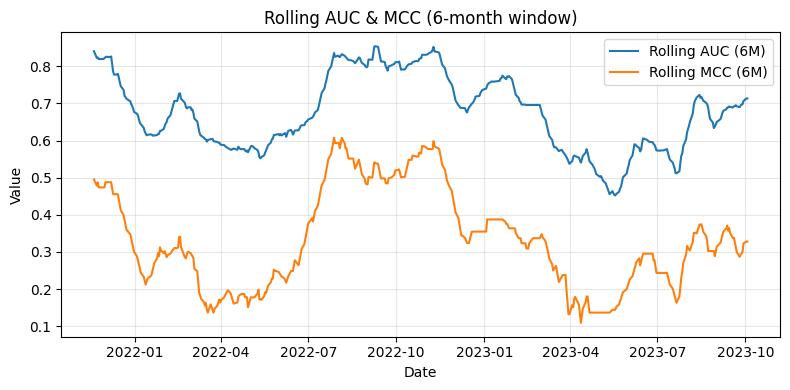

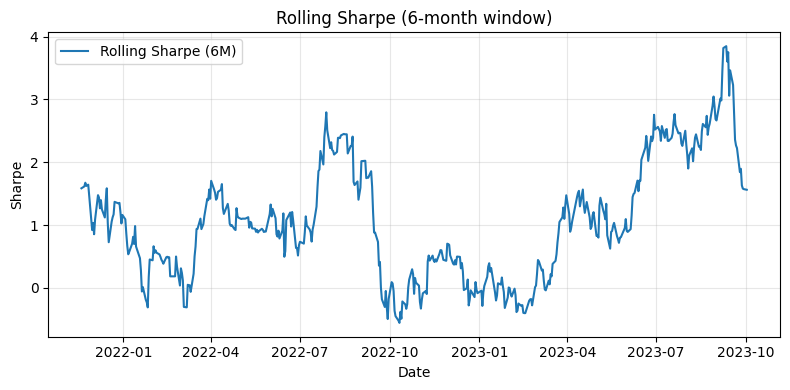

Saved plots to:
artifacts/checks/rolling_auc_mcc_6m.png
artifacts/checks/rolling_sharpe_6m.png


In [ ]:
# Plot rolling AUC/MCC and rolling Sharpe from saved CSV artifacts.
# This cell ONLY reads the CSVs produced earlier (18.3) and makes the plots.
# If the CSVs are missing, it will print a helpful message.

import pandas as pd, matplotlib.pyplot as plt
from pathlib import Path

ARTDIR = Path("artifacts/checks")
roll_path   = ARTDIR / "rolling_auc_mcc_6m.csv"
sharpe_path = ARTDIR / "rolling_sharpe_6m.csv"
DATE_COL = "Date"  # plots use this label on the x-axis

if not roll_path.exists() or not sharpe_path.exists():
    print("Missing CSVs. Please run Section 18.3 first to create:")
    print(f"- {roll_path}")
    print(f"- {sharpe_path}")
else:
    df_roll = pd.read_csv(roll_path)
    # some earlier cells saved the date column as 'date'; normalize it
    if 'date' in df_roll.columns and DATE_COL not in df_roll.columns:
        df_roll.rename(columns={'date': DATE_COL}, inplace=True)
    df_roll[DATE_COL] = pd.to_datetime(df_roll[DATE_COL])

    df_sh = pd.read_csv(sharpe_path)
    df_sh[DATE_COL] = pd.to_datetime(df_sh[DATE_COL])

    # --- Plot 1: Rolling AUC & MCC ---
    plt.figure(figsize=(8,4))
    plt.plot(df_roll[DATE_COL], df_roll["auc_6m"], label="Rolling AUC (6M)")
    plt.plot(df_roll[DATE_COL], df_roll["mcc_6m"], label="Rolling MCC (6M)")
    plt.title("Rolling AUC & MCC (6-month window)")
    plt.xlabel(DATE_COL); plt.ylabel("Value")
    plt.grid(True, alpha=0.3); plt.legend()
    plt.tight_layout()
    plt.savefig(ARTDIR / "rolling_auc_mcc_6m.png", dpi=150)
    plt.show()

    # --- Plot 2: Rolling Sharpe ---
    plt.figure(figsize=(8,4))
    plt.plot(df_sh[DATE_COL], df_sh["roll_sharpe_6m"], label="Rolling Sharpe (6M)")
    plt.title("Rolling Sharpe (6-month window)")
    plt.xlabel(DATE_COL); plt.ylabel("Sharpe")
    plt.grid(True, alpha=0.3); plt.legend()
    plt.tight_layout()
    plt.savefig(ARTDIR / "rolling_sharpe_6m.png", dpi=150)
    plt.show()

    print("Saved plots to:")
    print(str(ARTDIR / "rolling_auc_mcc_6m.png"))
    print(str(ARTDIR / "rolling_sharpe_6m.png"))


# **Summary and (Potential) Applications**

**Summary:**

This notebook presents a framework for building and evaluating a time-series classification model using fractal and volatility features derived solely from past price data. The core methodology involves a rigorous walk-forward validation scheme with a purge period to ensure robustness and prevent look-ahead bias. Key aspects include probability calibration, threshold optimization for maximizing the Matthews Correlation Coefficient (MCC), and a basic PnL (Profit and Loss) sanity check.





**Potential Use Cases and Applications:**

*   **Algorithmic Trading Signals:** The primary application is generating directional trading signals (long/short or long-only) for various financial instruments based on the predicted price movements.
*   **Risk Management:** The calibrated probabilities can be used for position sizing and risk management, allowing for more informed decisions based on the model's confidence.
*   **Quantitative Research:** The framework provides a solid foundation for further quantitative research into the predictive power of fractal and volatility features in different market conditions and asset classes.
*   **Feature Evaluation:** The permutation feature importance analysis helps identify which features are most relevant for prediction, guiding future feature engineering efforts.










**Improving Real-World Performance and Applications:**

The current model is intentionally limited to demonstrate a core framework with past-price features. For real-world applications, incorporating additional variables and parameters could significantly improve performance and broaden applicability:

*   **External Data Sources:** Integrating macroeconomic indicators, news sentiment, fundamental data, or alternative data sources (e.g., satellite imagery, social media trends) could provide valuable context beyond price history.
*   **Market Microstructure Data:** Including order book data, trade flow, and other high-frequency features could capture short-term market dynamics missed by daily or lower-frequency data.
*   **Adaptive Learning:** Implementing adaptive learning techniques where the model is retrained or updated more frequently based on recent data could help it adapt to changing market regimes.
*   **Transaction Cost Modeling:** More sophisticated modeling of transaction costs, including slippage based on order size and market liquidity, would provide a more realistic assessment of profitability.
*   **Risk-Adjusted Optimization:** Optimizing not just for MCC but for risk-adjusted returns (e.g., Sharpe Ratio, Sortino Ratio) during threshold selection or even within the training objective could lead to more practical trading strategies.
*   **Ensemble Methods:** Combining predictions from multiple models or different feature sets could improve robustness and predictive accuracy.
*   **Deep Learning Models:** Exploring more complex deep learning architectures designed for sequence data (e.g., LSTMs, Transformers) could potentially capture more intricate patterns.
*   **Dynamic Horizon/Barrier:** Instead of fixed horizons or barriers, dynamically adjusting them based on market volatility or other factors might yield better results.